In [3]:

from pathlib import Path

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
import statsmodels.formula.api as sm
import matplotlib.pylab as plt

import dmba
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/57662584/MMAI5000_group_14_project/refs/heads/main/Data-ATP-W119-PEW.csv')
print(df.head())
df.columns = [col[:-5] + '_W119' if col.lower().endswith('_w119') else col for col in df.columns]



     QKEY INTERVIEW_START_W119   INTERVIEW_END_W119  DEVICE_TYPE_W119  \
0  100314  12/13/2022 23:12:27  12/13/2022 23:23:59                 2   
1  100363  12/13/2022 19:50:59  12/13/2022 20:05:29                 2   
2  100598  12/14/2022 16:30:21  12/14/2022 16:47:21                 1   
3  100637  12/14/2022 08:22:09  12/14/2022 08:33:45                 1   
4  100803  12/15/2022 09:05:46  12/15/2022 09:22:29                 1   

   LANG_W119  FORM_W119  DESRISK_COMF_W119  DESRISK_CREAT_W119  \
0          1          1                  4                   3   
1          1          2                  3                   3   
2          1          1                  4                   4   
3          1          2                  2                   1   
4          1          2                  3                   3   

   DESRISK_NTECH_W119  RISK2_W119  ...  F_PARTYLN_FINAL  F_PARTYSUM_FINAL  \
0                   4           2  ...                                  1   
1         

C:\Users\User\AppData\Local\Temp\ipykernel_15100\2529272665.py:1: DtypeWarning: Columns (154) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('https://raw.githubusercontent.com/57662584/MMAI5000_group_14_project/refs/heads/main/Data-ATP-W119-PEW.csv')


In [5]:
columns_list = df.columns.tolist()
print(columns_list)
print(df.info())

['QKEY', 'INTERVIEW_START_W119', 'INTERVIEW_END_W119', 'DEVICE_TYPE_W119', 'LANG_W119', 'FORM_W119', 'DESRISK_COMF_W119', 'DESRISK_CREAT_W119', 'DESRISK_NTECH_W119', 'RISK2_W119', 'AI_HEARD_W119', 'CNCEXC_W119', 'USEAI_W119', 'AIKNOW1_W119', 'AIKNOW2_W119', 'AIKNOW3_W119', 'AIKNOW5_W119', 'AIKNOW6_W119', 'AIKNOW7_W119', 'AIKNOW1_CORRECT_W119', 'AIKNOW2_CORRECT_W119', 'AIKNOW3_CORRECT_W119', 'AIKNOW5_CORRECT_W119', 'AIKNOW6_CORRECT_W119', 'AIKNOW7_CORRECT_W119', 'AIKNOW_INDEX_W119', 'AIHCCOMF_W119', 'AIHCTRT1_W119', 'AIHCTRT2_W119', 'MEDBIAS_W119', 'AIHCCHG_QUAL_W119', 'AIHCCHG_MIST_W119', 'AIHCCHG_REL_W119', 'AIHCCHG_RACETHN_W119', 'AIHCCHG_SECUR_W119', 'HCMEDBIAS_W119', 'BIASBETR_OE1_W119', 'BIASBETR_OE2_W119', 'BIASBETR_OE3_W119', 'BIASBETR_REFUSED_W119', 'BIASWORS_OE1_W119', 'BIASWORS_OE2_W119', 'BIASWORS_OE3_W119', 'BIASWORS_REFUSED_W119', 'BIASSAME_OE1_W119', 'BIASSAME_OE2_W119', 'BIASSAME_OE3_W119', 'BIASSAME_REFUSED_W119', 'SCDETECT1_W119', 'SCDETECT2_W119', 'SCDETECT3_W119', 'S

In [6]:
# subjects from the dataset
healthcare_ai_vars = [
    'AIHCCOMF_W119',        # Comfort level with AI in healthcare
    'AIHCTRT1_W119',        # Perception of AI's impact on health outcomes (better or worse)
    'AIHCTRT2_W119',        # Concern about speed of AI development in healthcare (too fast or slow)
    'MEDBIAS_W119',         # Awareness of racial bias issues in healthcare
    'AIHCCHG_QUAL_W119',    # Perceived impact of AI on healthcare quality
    'AIHCCHG_MIST_W119',    # Perceived impact of AI on medical error rates
    'AIHCCHG_REL_W119',     # Perceived impact of AI on doctor-patient relationships
    'AIHCCHG_RACETHN_W119', # Perceived impact of AI on racial/ethnic fairness in healthcare
    'AIHCCHG_SECUR_W119',   # Perceived impact of AI on health data security
    'HCMEDBIAS_W119',       # Whether AI will improve or worsen racial bias in healthcare

    # Open-ended: reasons why AI could improve racial bias
    'BIASBETR_OE1_W119',    # Reason 1 (better)
    'BIASBETR_OE2_W119',    # Reason 2 (better)
    'BIASBETR_OE3_W119',    # Reason 3 (better)
    'BIASBETR_REFUSED_W119',# Refused to answer (better)

    # Open-ended: reasons why AI could worsen racial bias
    'BIASWORS_OE1_W119',    # Reason 1 (worse)
    'BIASWORS_OE2_W119',    # Reason 2 (worse)
    'BIASWORS_OE3_W119',    # Reason 3 (worse)
    'BIASWORS_REFUSED_W119',# Refused to answer (worse)

    # Open-ended: reasons why AI would have no effect
    'BIASSAME_OE1_W119',    # Reason 1 (same)
    'BIASSAME_OE2_W119',    # Reason 2 (same)
    'BIASSAME_OE3_W119',    # Reason 3 (same)
    'BIASSAME_REFUSED_W119' # Refused to answer (same)
]

personality_tech_vars = [
    'DESRISK_COMF_W119',  # Comfortable taking risks
    'DESRISK_CREAT_W119', # Creative thinker
    'DESRISK_NTECH_W119', # Enjoy using new technology
    'RISK2_W119'          # Taking risks usually pays off / leads to problems
]

ai_application_vars = [
    # Skin cancer detection
    'SCDETECT1_W119',  # Comfort with AI detecting skin cancer
    'SCDETECT2_W119',  # Accuracy perception of AI in skin cancer detection
    'SCDETECT3_W119',  # Preference for AI vs. human doctor
    'SCDETECT4_W119',  # Comfort with AI + human doctor combo

    # Mental health chatbot
    'AIMH1_W119',      # Helpfulness of AI mental health chatbot
    'AIMH2_W119',      # Comfort level with chatbot usage
    'AIMH3_W119',      # Trust in chatbot privacy
    'AIMH5_W119',      # Preference for chatbot vs human for mild cases

    # AI for pain medication dosage
    'AIPAIN1_W119',    # Accuracy belief
    'AIPAIN2_W119',    # Risk perception
    'AIPAIN3_W119',    # Doctor involvement
    'AIPAIN4_W119',    # Overall comfort

    # Surgical robots
    'SROBOT1_W119',    # Comfort level
    'SROBOT2_W119',    # Trust in performance
    'SROBOT3_W119',    # Risk perception

    # Protein structure prediction
    'AIPROT1_W119',    # Awareness
    'AIPROT2_W119',    # Perceived usefulness

    # Drought-resistant crops
    'AICROP1_W119',    # Awareness
    'AICROP2_W119',    # Perceived benefit

    # Extreme weather prediction
    'AIEXT1_W119',     # Helpfulness
    'AIEXT2_W119',     # Accuracy perception

    # AI-written news
    'AINEWS1_W119',    # Trustworthiness
    'AINEWS2_W119',    # Comfort level

    # AI-generated images/art
    'AIIMAG1_W119',    # Creativity impression
    'AIIMAG2_W119'     # Acceptability of AI art
]

employment_vars = [
    'EMPLSIT_W119',       # Current employment status
    'JOBAPPYR_W119',      # Applied for a job in the past year
  # 'INDUSTRY_W119',      # Industry (does not exist in the dataset)
    'INDUSTRYCOMBO_W119'  # Combined industry classification
]
workplace_econ_ai_vars = [
    # 'AIWRK1_W119',      # Description of AI role in your workplace
    'AIWRK2_a_W119',    # Impact on workers generally
    'AIWRK2_b_W119',    # Impact on you personally
    'AIWRK2_c_W119',    # Impact on U.S. economy
    'AIWRK3_a_W119',    # AI helps/hurts workers generally
    'AIWRK3_b_W119',    # AI helps/hurts you personally
    'AIWRK3_c_W119'     # AI helps/hurts U.S. economy
]

ai_hiring_fairness_vars = [
    'AIWRKH1_W119',          # Knowledge of AI hiring practices
    'AIWRKH2_a_W119',        # Support AI resume screening
    'AIWRKH2_b_W119',        # Support AI making final decisions
    'AIWRKH3_a_W119',        # AI vs. human: speed
    'AIWRKH3_b_W119',        # AI vs. human: fairness
    'AIWRKH3_c_W119',        # AI vs. human: accuracy
    'AIWRKH3_d_W119',        # AI vs. human: bias
    'AIWRKH4_W119',          # Willingness to apply to AI-hiring company
    'AIWRKH5Y_OE1_W119',     # Reason willing (1)
    'AIWRKH5Y_OE2_W119',
    'AIWRKH5Y_OE3_W119',
    'AIWRKH5Y_REFUSED_W119', # Refused reason (willing)
    'AIWRKH5N_OE1_W119',     # Reason not willing (1)
    'AIWRKH5N_OE2_W119',
    'AIWRKH5N_OE3_W119',
    'AIWRKH5N_REFUSED_W119', # Refused reason (not willing)
    'HIREBIAS1_W119',        # Hiring bias perception
    'HIREBIAS2_W119'         # Can AI improve or worsen hiring bias
]

workplace_monitoring_vars = [
    'AIWRKM1_W119',      # Awareness of AI workplace monitoring
    'AIWRKM2_a_W119',    # Monitoring presence
    'AIWRKM2_b_W119',    # Recording computer activity
    'AIWRKM2_c_W119',    # Tracking movement
    'AIWRKM2_d_W119',    # Monitoring driving
    'AIWRKM2_e_W119',    # Evaluating performance
    'AIWRKM2_f_W119',    # Monitoring retail interactions
    'AIWRKM3_a_W119',    # Belief: same evaluation standard
    'AIWRKM3_b_W119',    # Concern: data misuse
    'AIWRKM3_c_W119',    # Benefit: better security
    'AIWRKM3_d_W119',    # Benefit: less misconduct
    'AIWRKM3_e_W119',    # Benefit: increased profits
    'AIWRKM3_f_W119',    # Drawback: feeling watched
    'AIWRKM4_a_W119',    # Use data for promotions
    'AIWRKM4_b_W119',    # Use data for firings
    'EVALBIAS1_W119',    # Bias in performance evaluations
    'EVALBIAS2_W119'     # Can AI help/hurt bias in evaluations
]

facial_recognition_vars = [
    'FACERECWK1_W119',      # Awareness of employer's use of facial recognition
    'FACERECWK2_a_W119',    # Use for tracking attendance
    'FACERECWK2_b_W119',    # Use for analyzing facial expressions
    'FACERECWK2_c_W119',    # Use for monitoring break frequency
    'FACERECWK3_a_W119',    # Concern: misidentification of employees
    'FACERECWK3_b_W119',    # Concern: racial bias in facial recognition
    'FACERECWK3_c_W119'     # Concern: misinterpretation of facial expressions
]

twitter_vars = [
    'TWITTER1_MOD_W119',    # Has Twitter account
    # 'TWITTER2_W119',      # Willing to share Twitter handle 
    # 'TWITTER3_W119'       # Twitter handle itself （these does not exist in the dataset）
]
demographic_vars = [
    # 'AGE',                # Respondent age
    # 'GENDER',             # Gender
    # 'EDUCATION',          # Education level
    # 'RACE',               # Race/ethnicity
    'WEIGHT_W119',        # Sample weight for weighting responses

    'F_GENDER',           # Gender (coded)
    'F_AGECAT',           # Age category
    'F_EDUCCAT',          # Education category
    'F_HISP',             # Hispanic origin
    'F_RACECMB',          # Combined race code

    # Political identity
    'F_PARTY_FINAL',      # Final party ID
    'F_PARTYLN_FINAL',    # Final party lean
    'F_PARTYSUM_FINAL',   # Final summarized party ID
    'F_PARTYSUMIDEO_FINAL', # Party + ideology summary

    # Socioeconomic/personal factors
    'F_INC_SDT1',         # Income category
    'F_IDEO',             # Ideology
    'F_INTFREQ',          # Internet frequency
    'F_REG',              # Voter registration
    'F_VOLSUM',           # Volunteering behavior
    'F_INC_TIER2'         # Income tier (alt variable)
]

ai_know_vars = [
    # Individual scenario answers (corrected)
    'AIKNOW1_CORRECT_W119',  # Correctness: Customer service scenario
    'AIKNOW2_CORRECT_W119',  # Correctness: Music-playing device
    'AIKNOW3_CORRECT_W119',  # Correctness: Email reading
    'AIKNOW5_CORRECT_W119',  # Correctness: Health product recommendation
    'AIKNOW6_CORRECT_W119',  # Correctness: Online shopping AI
    'AIKNOW7_CORRECT_W119',  # Correctness: Smart home device

    # Raw responses to the same scenarios
    'AIKNOW1_W119', 
    'AIKNOW2_W119', 
    'AIKNOW3_W119',
    'AIKNOW5_W119', 
    'AIKNOW6_W119', 
    'AIKNOW7_W119',

    'AIKNOW_INDEX_W119'      # Aggregated AI knowledge index
]

ai_attitude_vars = [
    'AI_HEARD_W119',  # How much have you heard or read about AI
    'CNCEXC_W119',    # Does AI make you more excited or concerned
    'USEAI_W119'      # How often do you interact with AI
]


other_vars = [
    'QKEY',                 # Unique respondent identifier
    'INTERVIEW_START_W119',# Interview start time
    'INTERVIEW_END_W119',  # Interview end time
    'DEVICE_TYPE_W119',    # Device used to complete survey
    'LANG_W119',           # Language used in the survey
    'FORM_W119',           # Random form assignment (if split-ballot)

    # Additional demographic background
    'F_METRO',              # Metro status
    'F_CREGION',            # Census region
    'F_CDIVISION',          # Census division
    'F_USR_SELFID',         # Self-reported U.S. region
    'F_EDUCCAT2',           # Alternate education categorization
    'F_HISP_ORIGIN',        # Detailed Hispanic origin
    'F_YEARSINUS_RECODE',   # Years in the U.S.
    'F_RACETHNMOD',         # Modified race/ethnicity
    'F_CITIZEN',            # Citizenship status
    'F_BIRTHPLACE',         # Birthplace
    'F_MARITAL',            # Marital status
    'F_RELIG',              # Religion
    'F_BORN',               # Born in U.S. or elsewhere
    'F_RELIGCAT1',          # Religion category
    'F_ATTEND'              # Religious service attendance frequency
]






In [7]:
#print(df.shape)      
#print(df.head())     
#print(df.tail())     
#print(df.info())     
#print(df.describe().T) 
#print(df.isnull().sum())   
#print(df.duplicated().sum()) 

# for subject_name, var_list in subject_vars.items():
#     print(f"Subject: {subject_name}")
#     for var in var_list:
#         print(f"  - {var}")

        
# df_ai_know = df[ai_know_vars]
# print(df_ai_know.describe().T)
# print(df_ai_know.info())

# for col in df_ai_know.columns:
#     plt.figure(figsize=(5,3))
#     df_ai_know[col].value_counts(dropna=False).sort_index().plot(kind='bar')
#     plt.title(f'{col} distribution')
#     plt.xlabel(col)
#     plt.ylabel('number')
#     plt.show()


In [28]:
# define function analyze_subject(df, var_list)

def analyze_subject(df, var_list):
    existing_vars = [var for var in var_list if var in df.columns]
    if not existing_vars:
        return

    df_subset = df[existing_vars]

    print(df_subset.describe(include='all').T)
    print(df_subset.info())

    for col in df_subset.columns:
        plt.figure(figsize=(5, 3))
        df_subset[col].value_counts(dropna=False).sort_index().plot(kind='bar')
        plt.title(f'{col} Histogram')
        plt.xlabel(col)
        plt.ylabel('count')
        plt.tight_layout()
        plt.show()



                      count      mean       std  min  25%  50%  75%   max
DESRISK_COMF_W119   11004.0  2.989549  2.593657  1.0  2.0  3.0  4.0  99.0
DESRISK_CREAT_W119  11004.0  2.391130  2.431065  1.0  2.0  2.0  3.0  99.0
DESRISK_NTECH_W119  11004.0  2.582697  2.788196  1.0  2.0  3.0  3.0  99.0
RISK2_W119          11004.0  2.383588  9.631999  1.0  1.0  1.0  2.0  99.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11004 entries, 0 to 11003
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   DESRISK_COMF_W119   11004 non-null  int64
 1   DESRISK_CREAT_W119  11004 non-null  int64
 2   DESRISK_NTECH_W119  11004 non-null  int64
 3   RISK2_W119          11004 non-null  int64
dtypes: int64(4)
memory usage: 344.0 KB
None


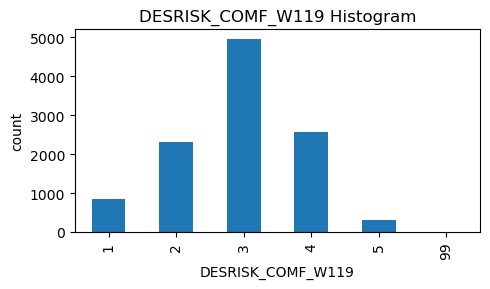

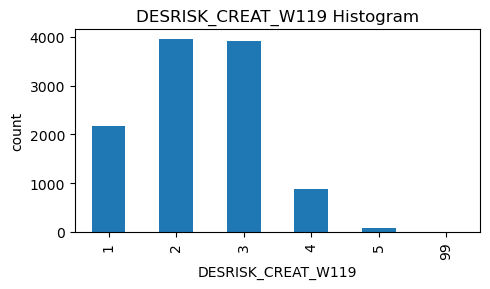

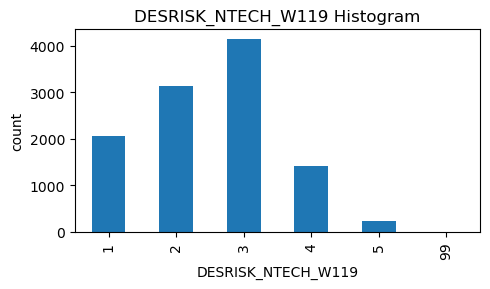

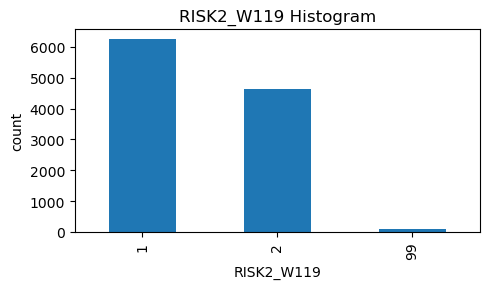

In [9]:
analyze_subject(df, personality_tech_vars)

                 count      mean        std  min  25%  50%  75%   max
AI_HEARD_W119  11004.0  1.911123   2.688112  1.0  1.0  2.0  2.0  99.0
CNCEXC_W119    11004.0  3.113413   8.834480  1.0  2.0  2.0  3.0  99.0
USEAI_W119     11004.0  4.845420  10.774278  1.0  2.0  4.0  5.0  99.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11004 entries, 0 to 11003
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   AI_HEARD_W119  11004 non-null  int64
 1   CNCEXC_W119    11004 non-null  int64
 2   USEAI_W119     11004 non-null  int64
dtypes: int64(3)
memory usage: 258.0 KB
None


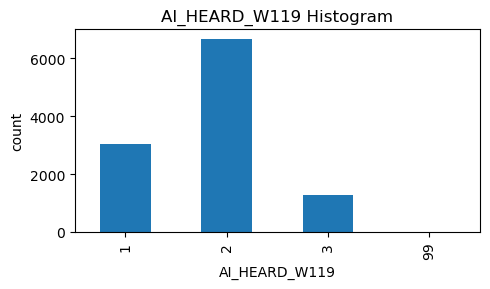

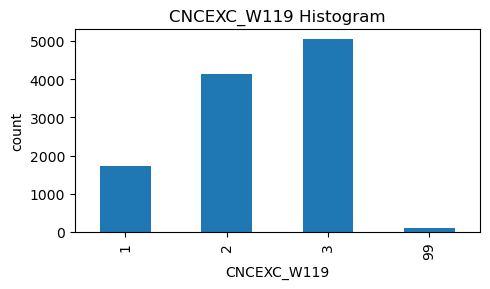

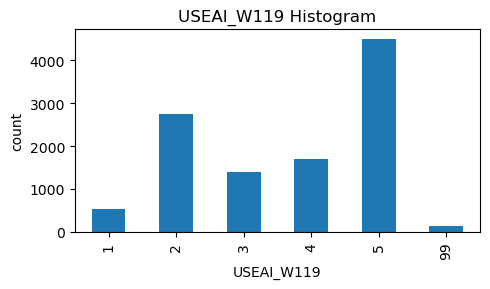

In [10]:
analyze_subject(df, ai_attitude_vars)

                         count unique  top   freq      mean        std  min  \
AIHCCOMF_W119          11004.0    NaN  NaN    NaN  3.251999   7.023469  1.0   
AIHCTRT1_W119          11004.0    NaN  NaN    NaN  3.703835  13.252228  1.0   
AIHCTRT2_W119          11004.0    NaN  NaN    NaN  2.988459  13.003679  1.0   
MEDBIAS_W119           11004.0    NaN  NaN    NaN  3.465649  12.275711  1.0   
AIHCCHG_QUAL_W119      11004.0    NaN  NaN    NaN   3.15767  10.348817  1.0   
AIHCCHG_MIST_W119      11004.0    NaN  NaN    NaN   3.26554  11.585953  1.0   
AIHCCHG_REL_W119       11004.0    NaN  NaN    NaN  2.993184   8.885789  1.0   
AIHCCHG_RACETHN_W119   11004.0    NaN  NaN    NaN  3.103599  10.069169  1.0   
AIHCCHG_SECUR_W119     11004.0    NaN  NaN    NaN  3.139131   9.574934  1.0   
HCMEDBIAS_W119         11004.0    NaN  NaN    NaN  4.146947  12.125676  1.0   
BIASBETR_OE1_W119        11004     10        8473       NaN        NaN  NaN   
BIASBETR_OE2_W119        11004      7       10721   

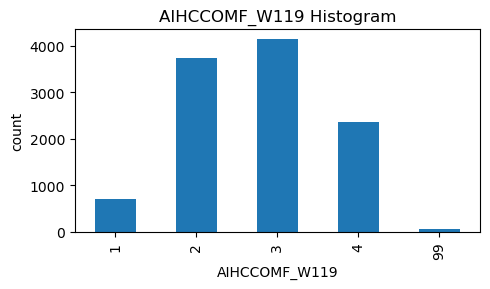

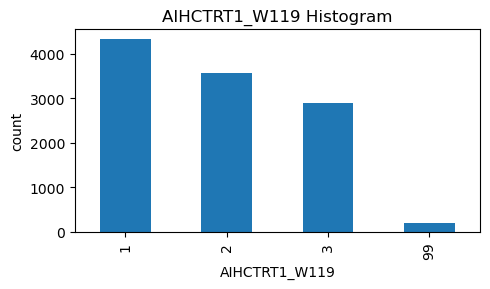

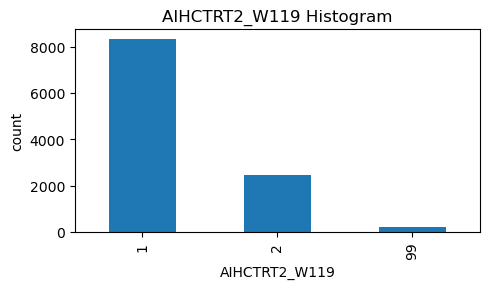

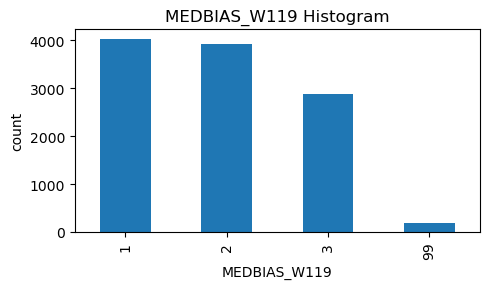

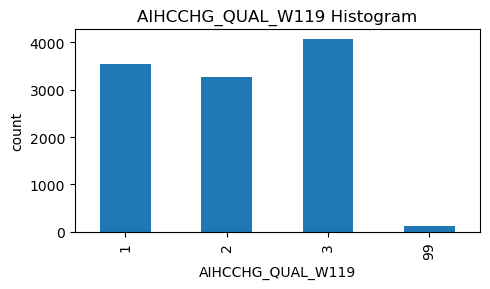

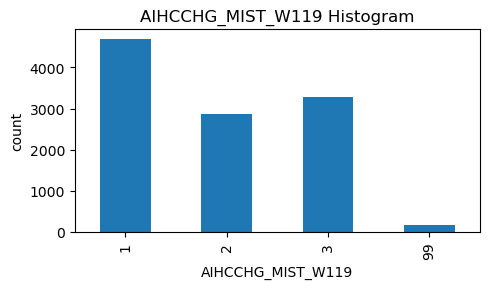

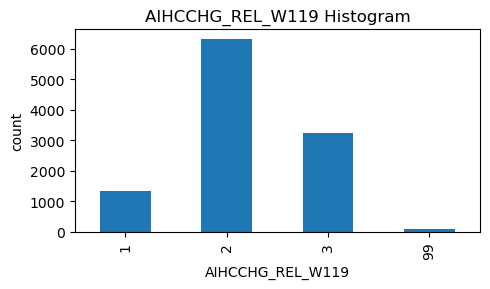

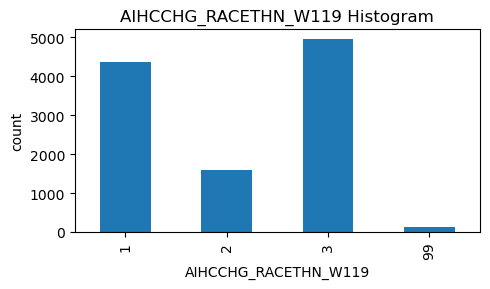

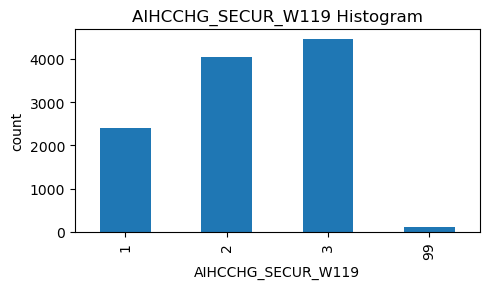

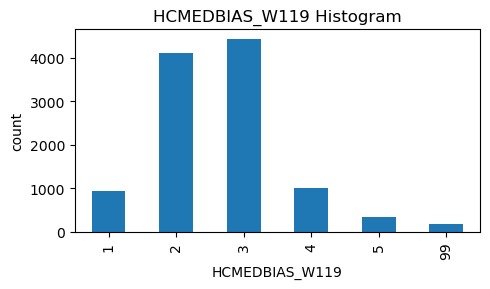

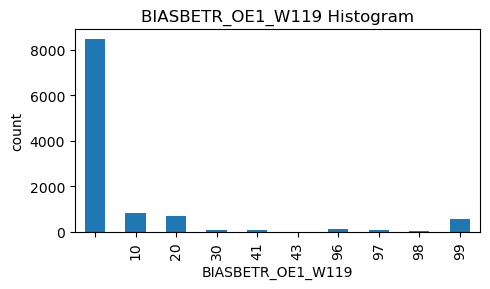

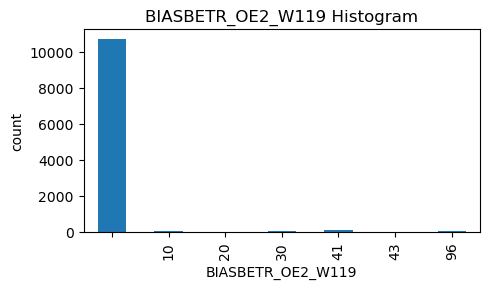

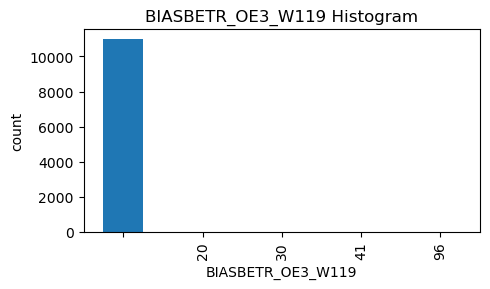

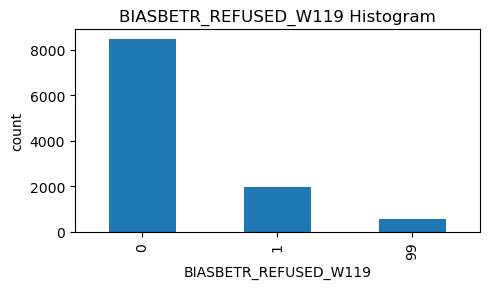

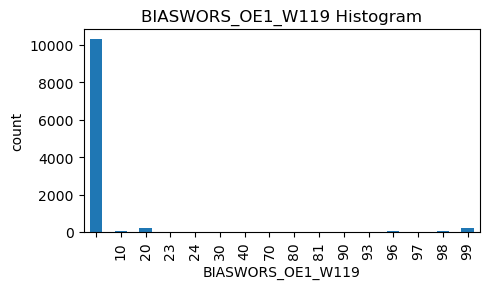

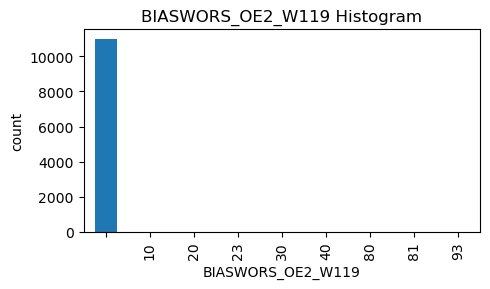

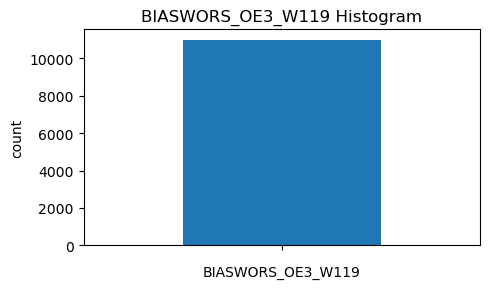

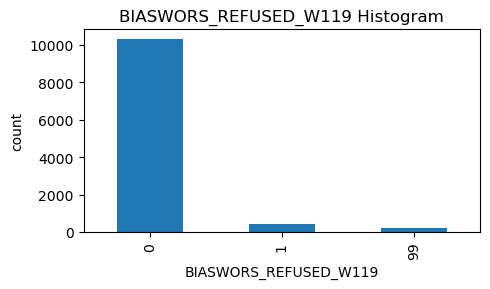

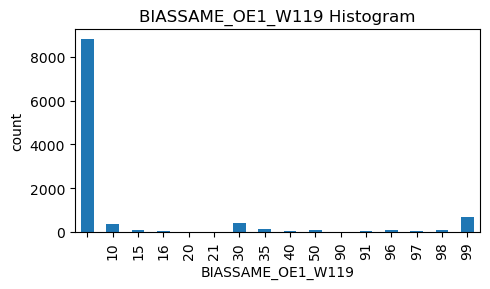

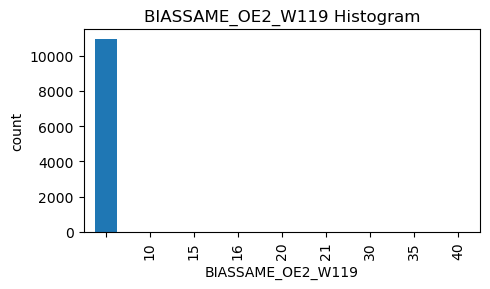

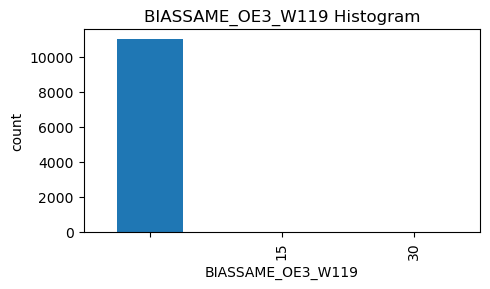

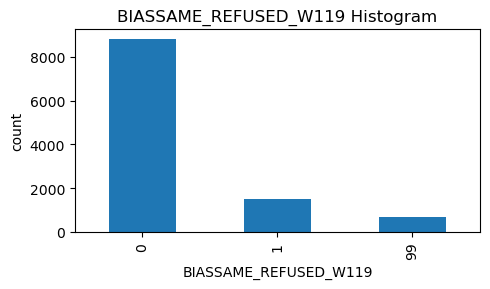

In [11]:
analyze_subject(df, healthcare_ai_vars)

                count unique top  freq
SCDETECT1_W119  11004      5      5493
SCDETECT2_W119  11004      6      5493
SCDETECT3_W119  11004      6      5493
SCDETECT4_W119  11004      5      5493
AIMH1_W119      11004      5      5493
AIMH2_W119      11004      6      5493
AIMH3_W119      11004      6      5493
AIMH5_W119      11004      5      5493
AIPAIN1_W119    11004      5      5511
AIPAIN2_W119    11004      6      5511
AIPAIN3_W119    11004      6      5511
AIPAIN4_W119    11004      5      5511
SROBOT1_W119    11004      5      5511
SROBOT2_W119    11004      6      5511
SROBOT3_W119    11004      6      5511
AIPROT1_W119    11004      5      5493
AIPROT2_W119    11004      6      5493
AICROP1_W119    11004      5      5493
AICROP2_W119    11004      6      5493
AIEXT1_W119     11004      5      5511
AIEXT2_W119     11004      6      5511
AINEWS1_W119    11004      5      5493
AINEWS2_W119    11004      6      5493
AIIMAG1_W119    11004      5      5511
AIIMAG2_W119    11004    

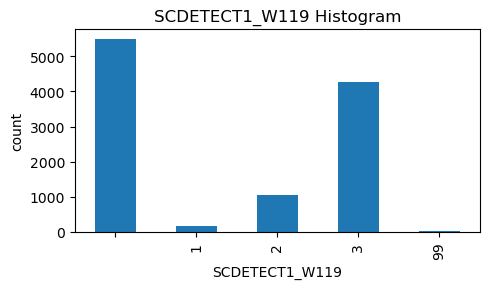

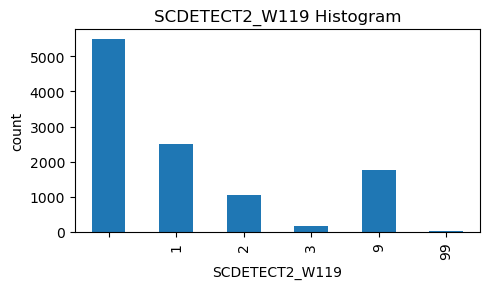

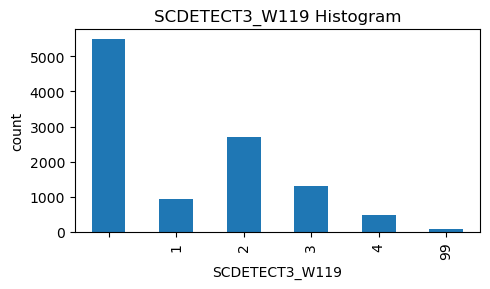

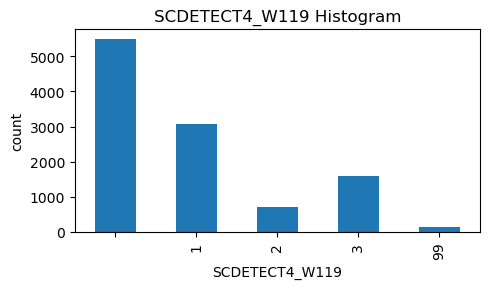

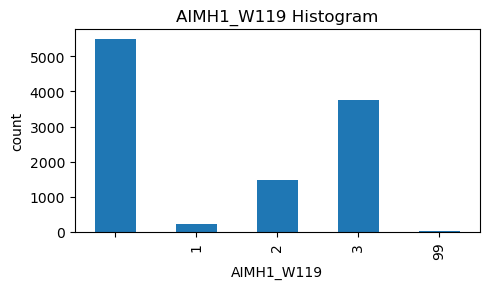

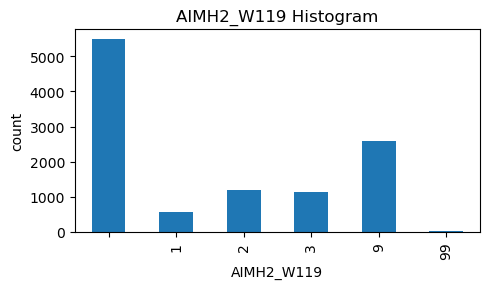

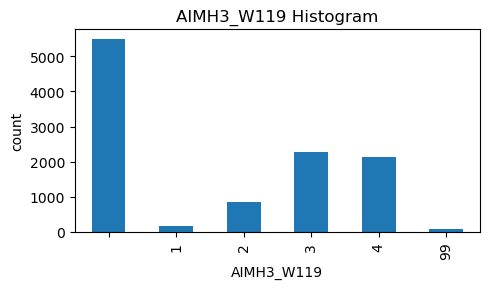

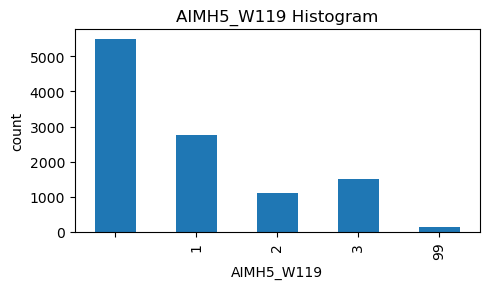

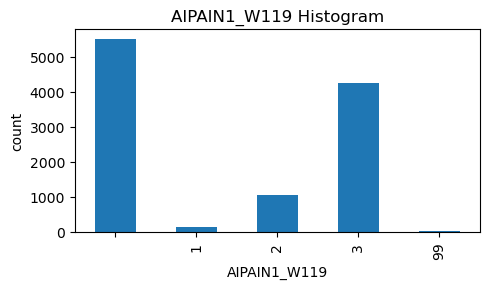

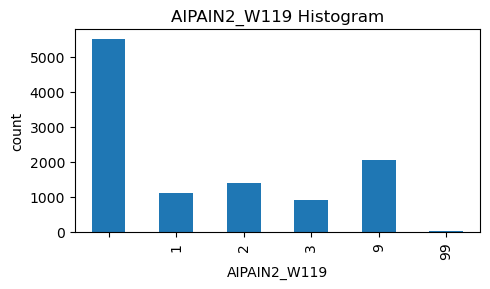

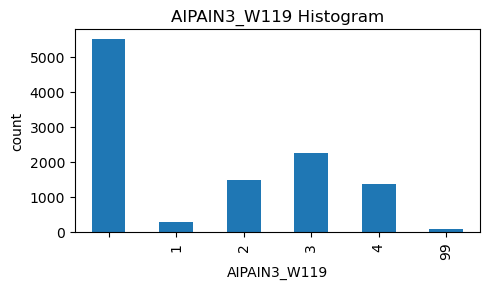

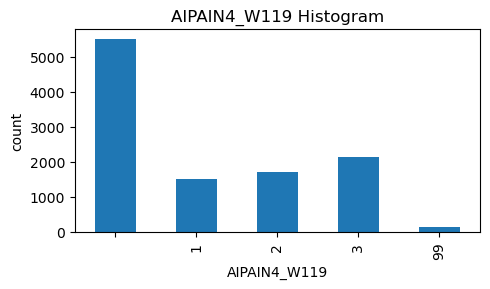

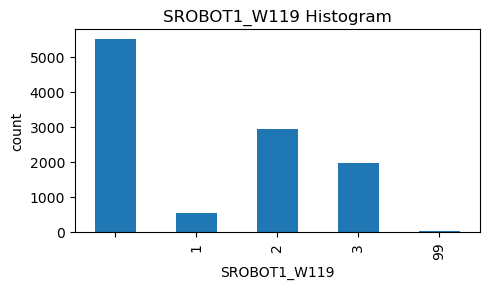

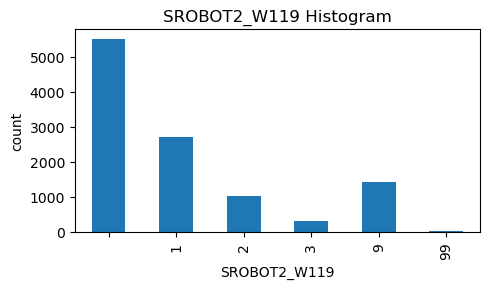

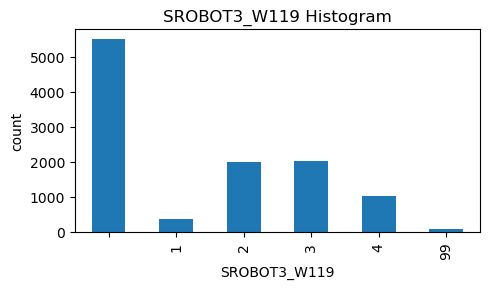

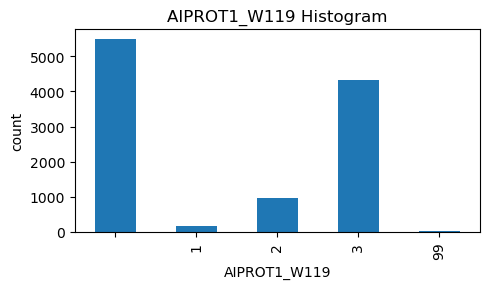

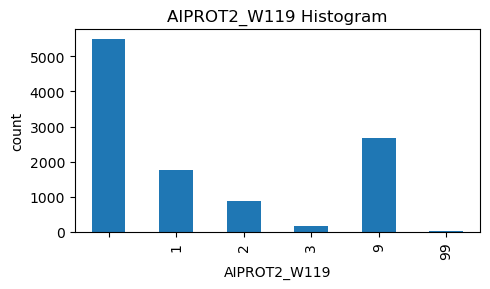

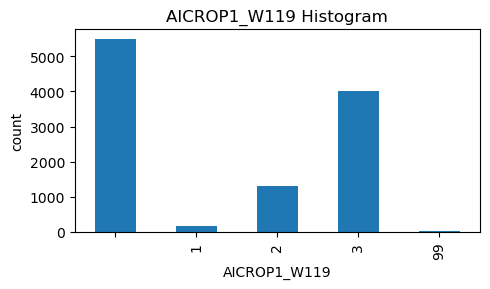

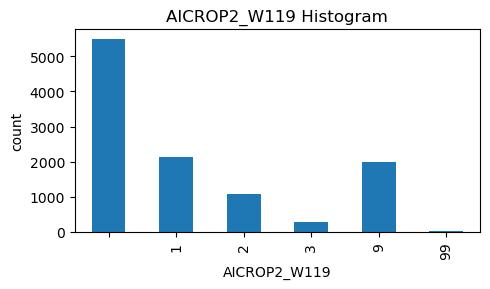

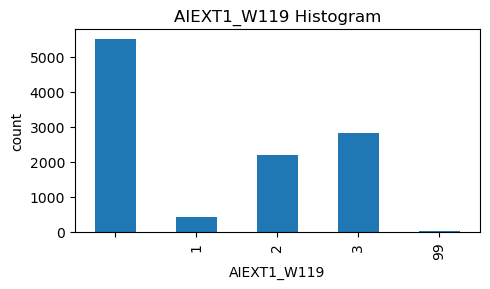

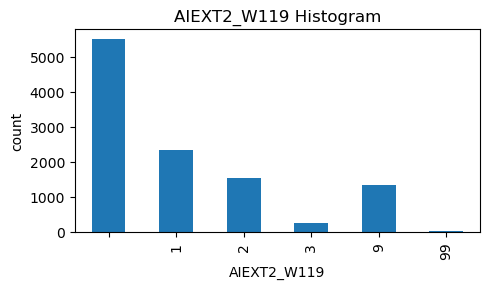

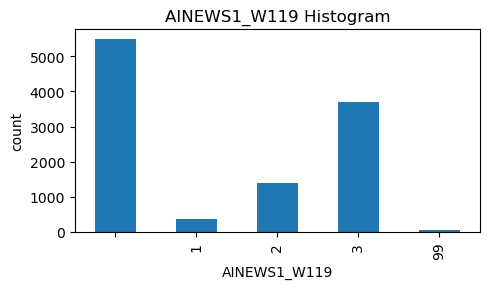

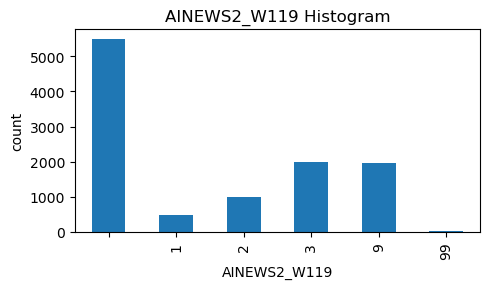

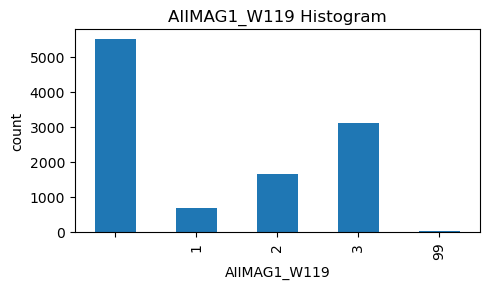

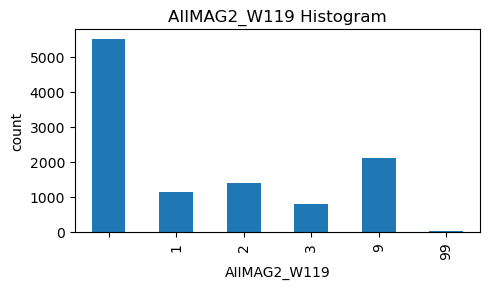

In [12]:
analyze_subject(df, ai_application_vars)

                      count unique  top  freq      mean       std  min  25%  \
EMPLSIT_W119        11004.0    NaN  NaN   NaN  2.913032  6.325789  1.0  1.0   
JOBAPPYR_W119       11004.0    NaN  NaN   NaN  1.979189  4.555775  1.0  2.0   
INDUSTRYCOMBO_W119    11004     13       4507       NaN       NaN  NaN  NaN   

                    50%  75%   max  
EMPLSIT_W119        2.0  5.0  99.0  
JOBAPPYR_W119       2.0  2.0  99.0  
INDUSTRYCOMBO_W119  NaN  NaN   NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11004 entries, 0 to 11003
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   EMPLSIT_W119        11004 non-null  int64 
 1   JOBAPPYR_W119       11004 non-null  int64 
 2   INDUSTRYCOMBO_W119  11004 non-null  object
dtypes: int64(2), object(1)
memory usage: 258.0+ KB
None


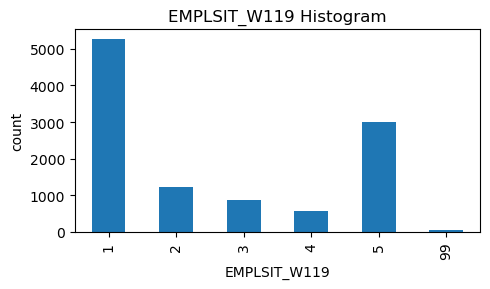

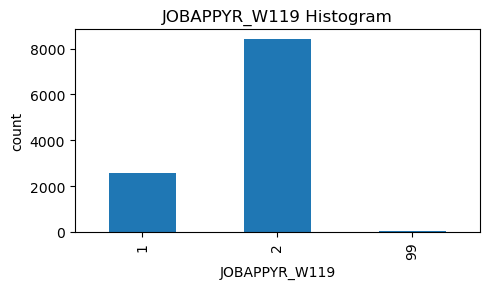

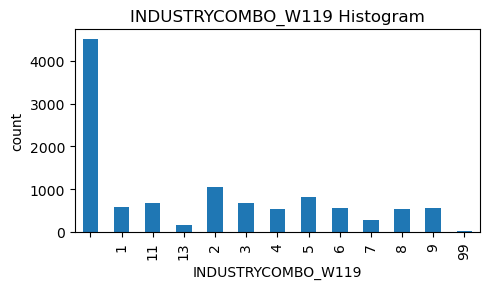

In [13]:
analyze_subject(df, employment_vars)

                         count unique  top   freq       mean        std  min  \
AIWRKH1_W119           11004.0    NaN  NaN    NaN   2.838422   5.621177  1.0   
AIWRKH2_a_W119         11004.0    NaN  NaN    NaN   4.093511   6.488553  1.0   
AIWRKH2_b_W119         11004.0    NaN  NaN    NaN   3.636314   5.682282  1.0   
AIWRKH3_a_W119         11004.0    NaN  NaN    NaN   4.129226   7.751305  1.0   
AIWRKH3_b_W119         11004.0    NaN  NaN    NaN   3.722646    7.78266  1.0   
AIWRKH3_c_W119         11004.0    NaN  NaN    NaN   4.247183   7.772974  1.0   
AIWRKH3_d_W119         11004.0    NaN  NaN    NaN   4.549255   7.934513  1.0   
AIWRKH4_W119           11004.0    NaN  NaN    NaN   3.712741  14.023296  1.0   
AIWRKH5Y_OE1_W119        11004     14        7250        NaN        NaN  NaN   
AIWRKH5Y_OE2_W119        11004     12       10731        NaN        NaN  NaN   
AIWRKH5Y_OE3_W119        11004      7       10985        NaN        NaN  NaN   
AIWRKH5Y_REFUSED_W119  11004.0    NaN  N

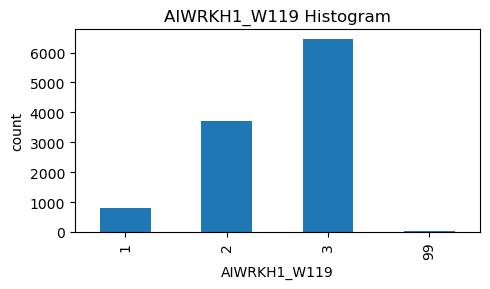

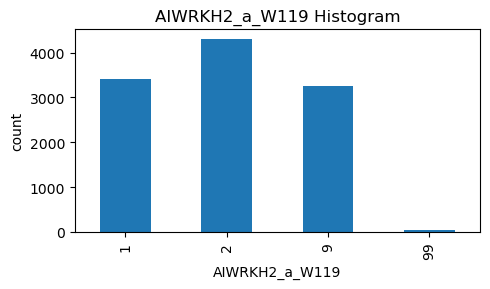

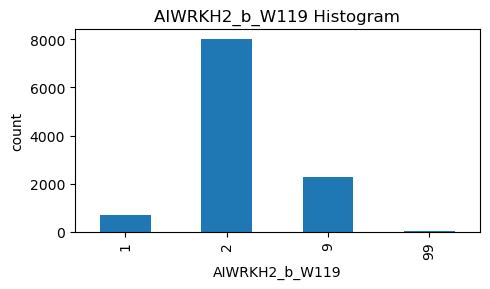

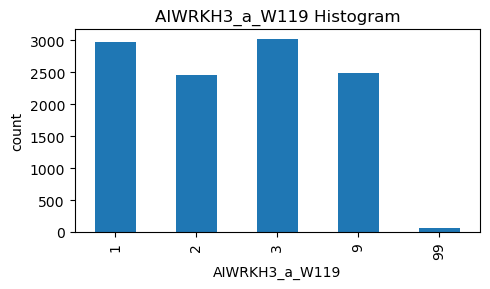

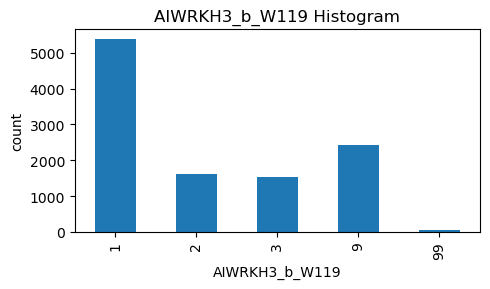

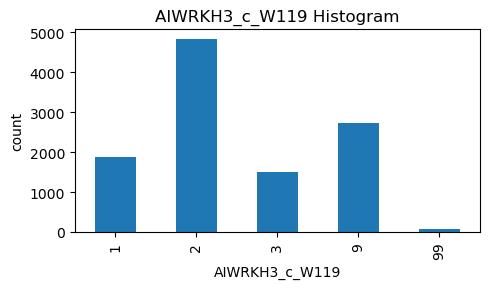

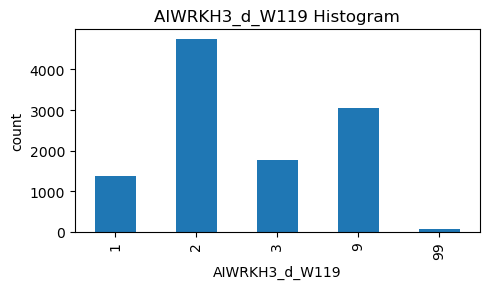

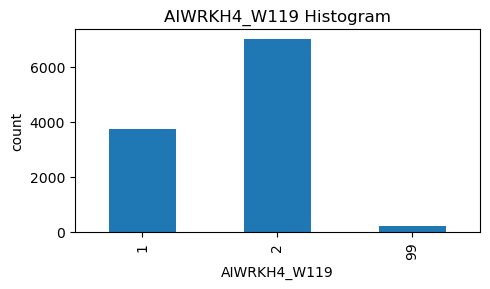

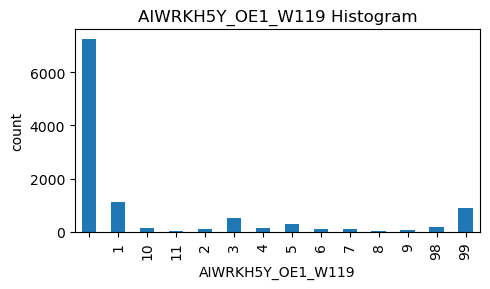

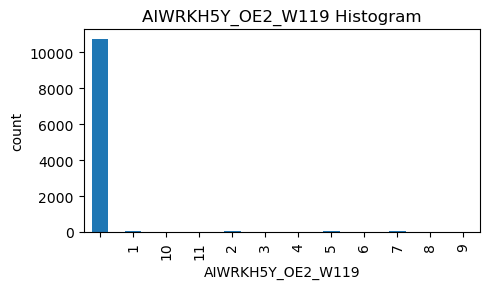

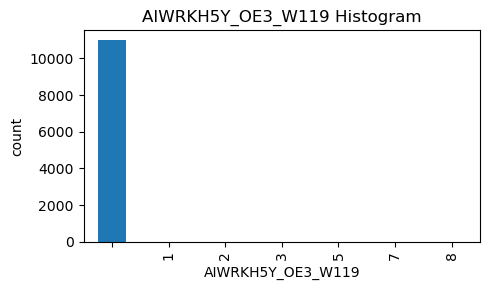

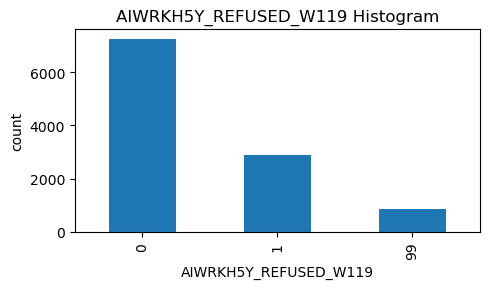

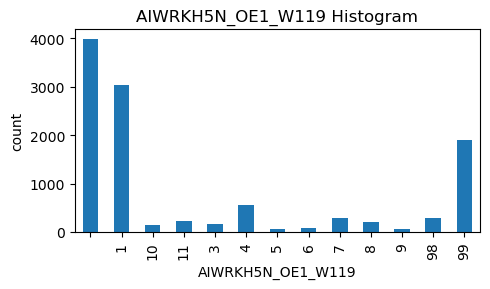

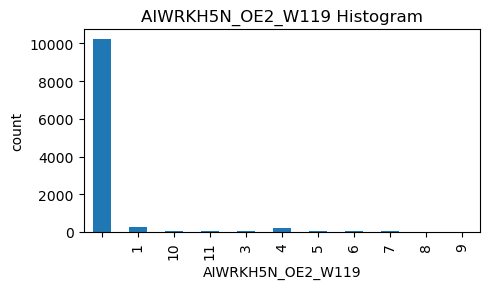

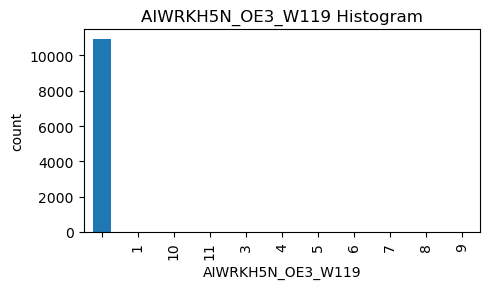

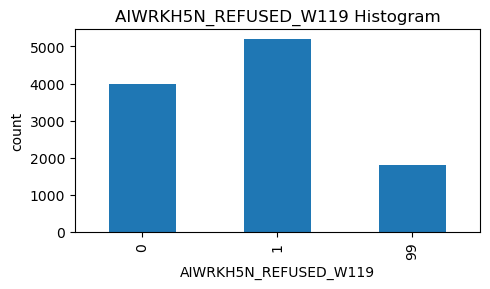

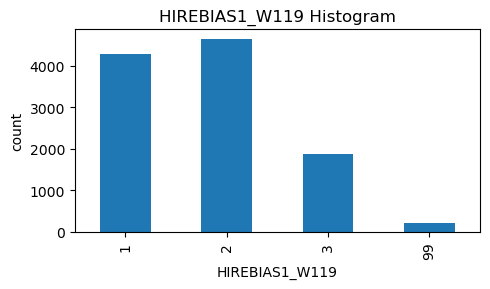

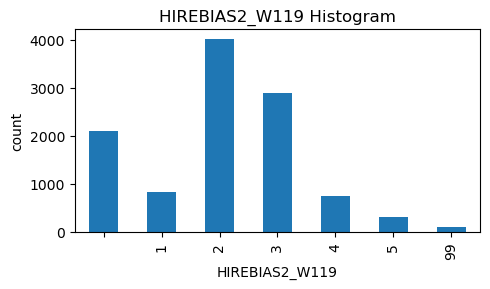

In [14]:

analyze_subject(df, ai_hiring_fairness_vars)

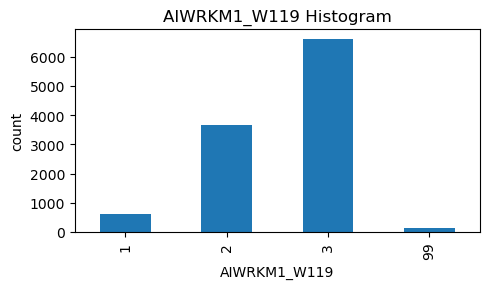

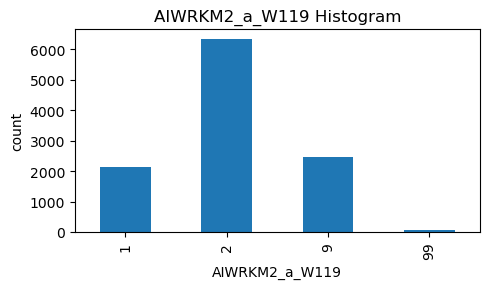

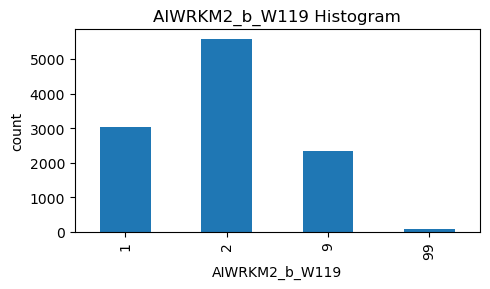

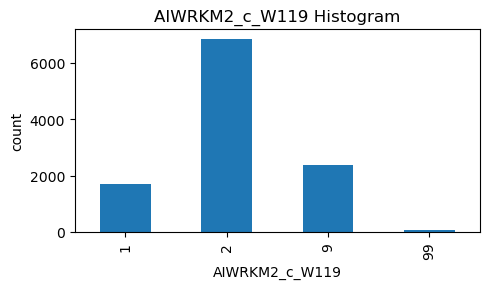

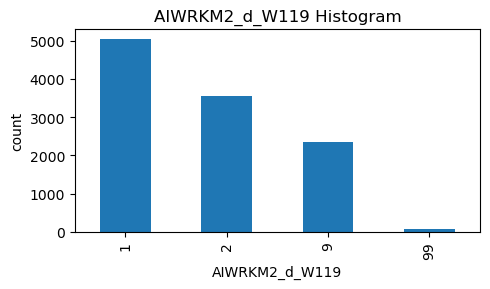

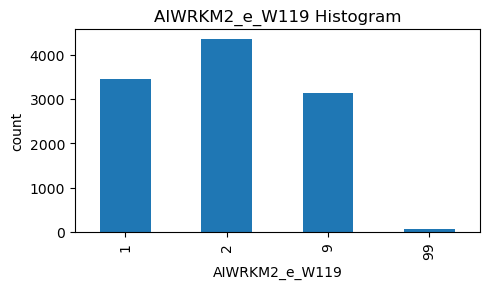

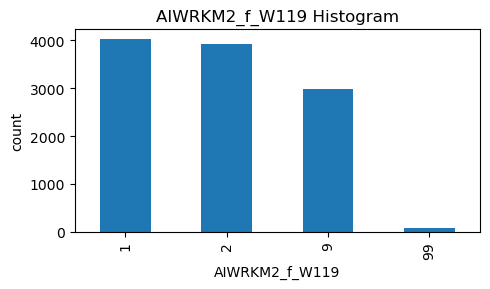

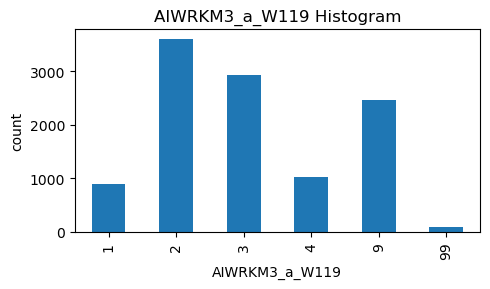

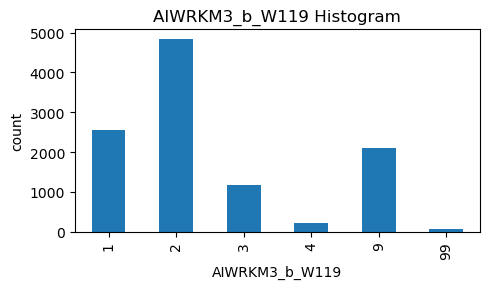

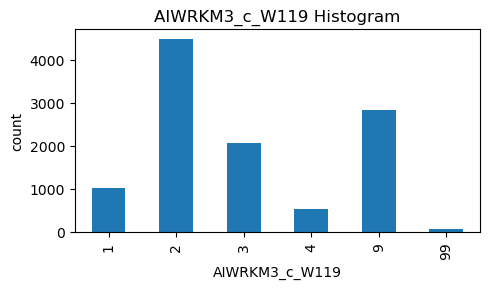

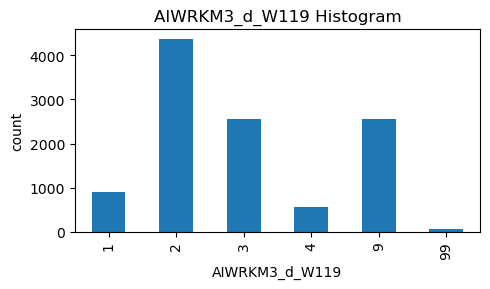

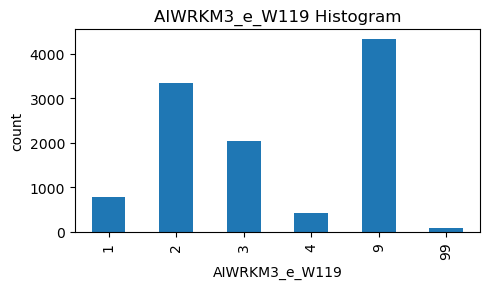

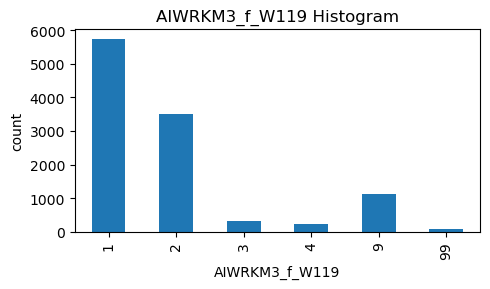

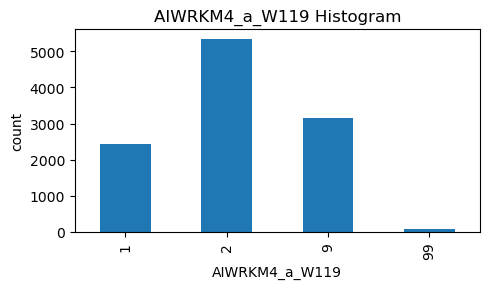

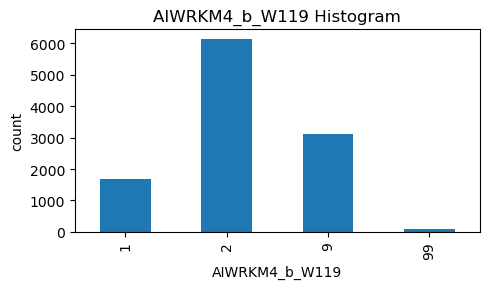

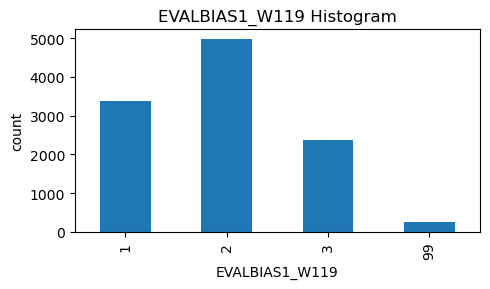

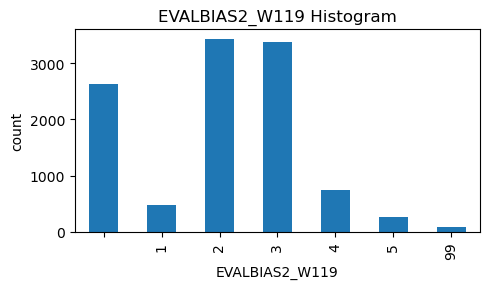

In [15]:
def hist_subject(df, var_list):
	existing_vars = [var for var in var_list if var in df.columns]
	if not existing_vars:
		return

	df_subset = df[existing_vars]

	for col in df_subset.columns:
		plt.figure(figsize=(5, 3))
		df_subset[col].value_counts(dropna=False).sort_index().plot(kind='bar')
		plt.title(f'{col} Histogram')
		plt.xlabel(col)
		plt.ylabel('count')
		plt.tight_layout()
		plt.show()

hist_subject(df, workplace_monitoring_vars)

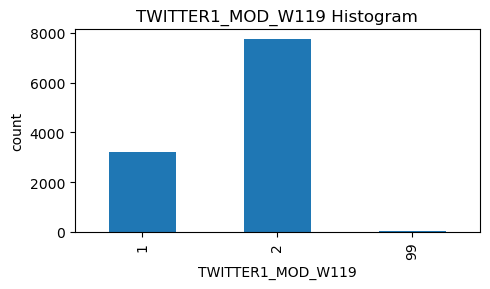

In [16]:
hist_subject(df, twitter_vars)

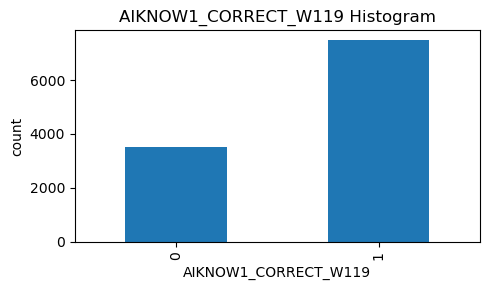

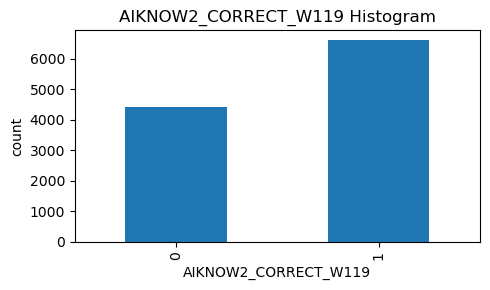

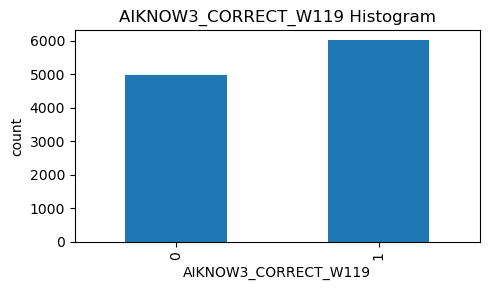

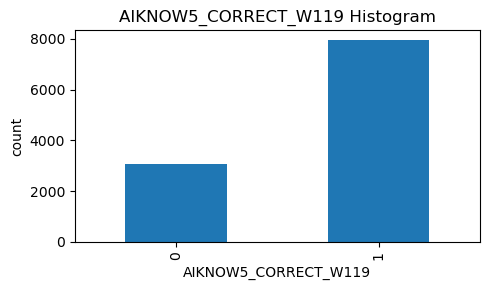

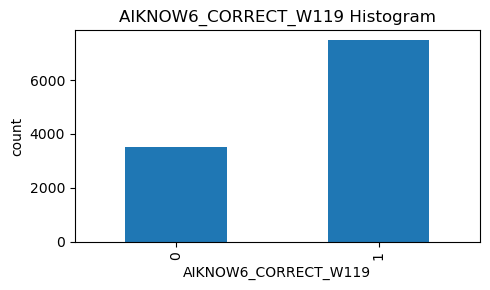

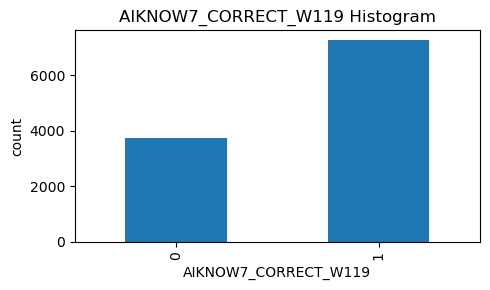

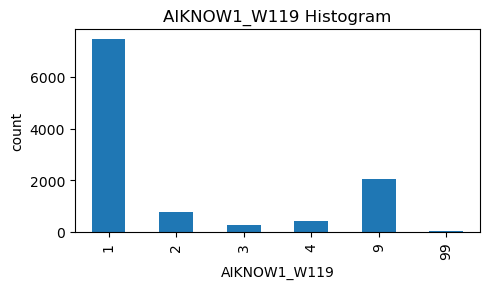

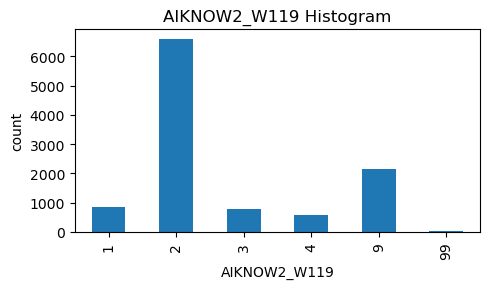

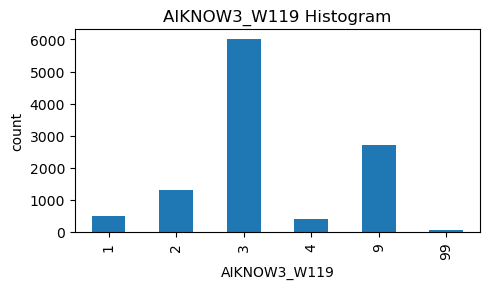

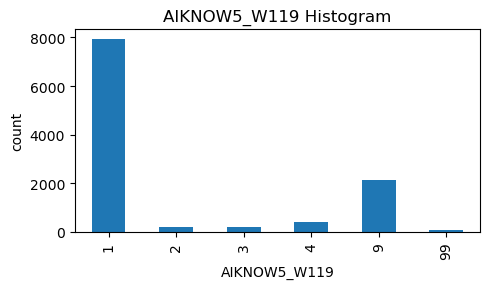

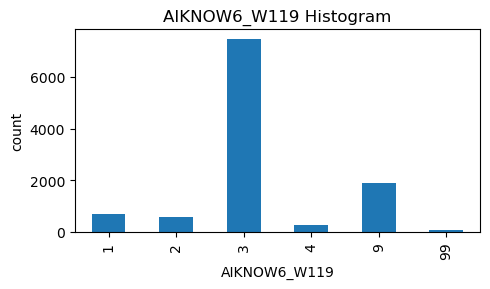

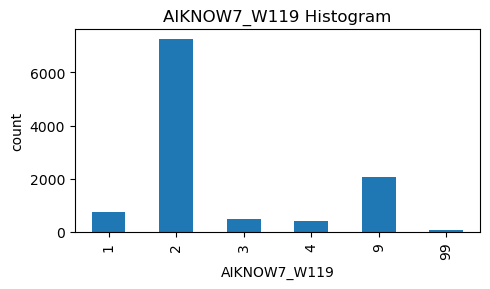

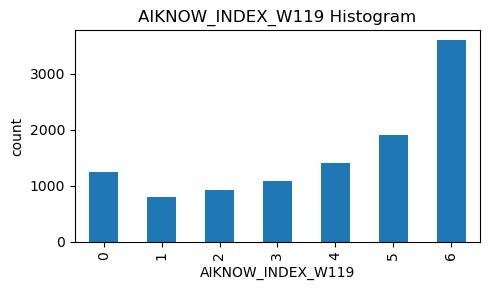

In [17]:

hist_subject(df, ai_know_vars)


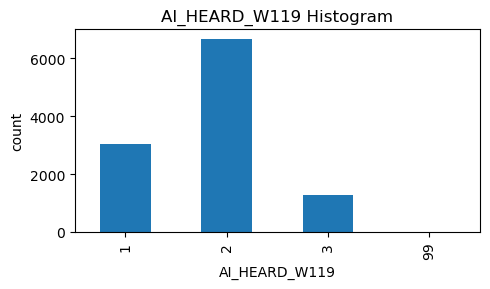

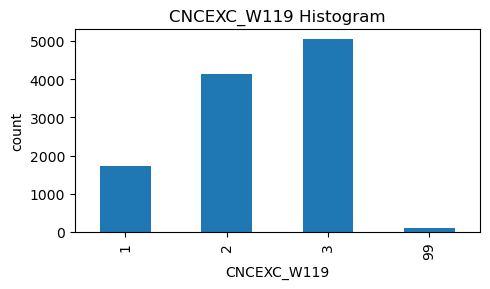

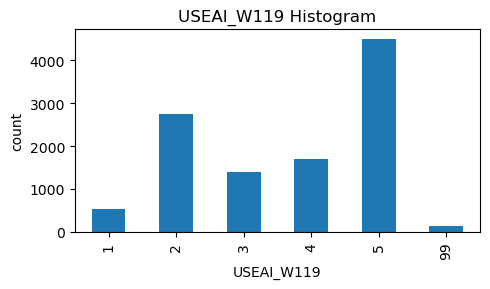

In [18]:
hist_subject(df,ai_attitude_vars )

In [19]:
def infer_var_types(df, threshold=10):
    cat_vars = []
    num_vars = []
    for col in df.columns:
        if df[col].dtype == 'object':
            cat_vars.append(col)
        elif df[col].nunique() <= threshold:
            cat_vars.append(col)
        else:
            num_vars.append(col)
    return cat_vars, num_vars

cat_vars, num_vars = infer_var_types(df)
print(" Categorical vars:", cat_vars[:10])
print(" Numerical vars:", num_vars[:10])


 Categorical vars: ['INTERVIEW_START_W119', 'INTERVIEW_END_W119', 'DEVICE_TYPE_W119', 'LANG_W119', 'FORM_W119', 'DESRISK_COMF_W119', 'DESRISK_CREAT_W119', 'DESRISK_NTECH_W119', 'RISK2_W119', 'AI_HEARD_W119']
 Numerical vars: ['QKEY', 'F_RELIG', 'WEIGHT_W119']


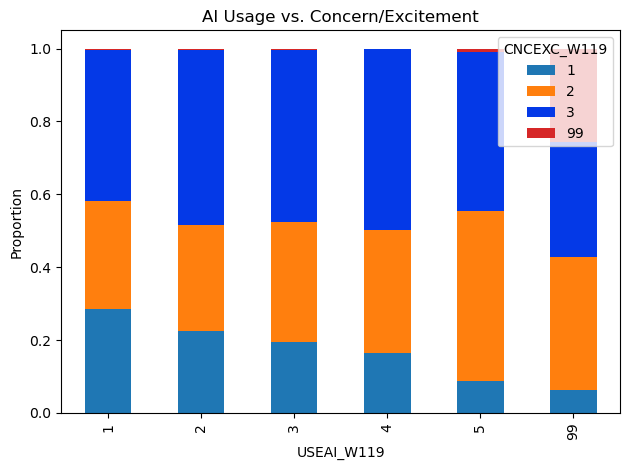

In [20]:
colors = ['#1f77b4', '#ff7f0e', "#0439e7", '#d62728']  
pd.crosstab(df['USEAI_W119'], df['CNCEXC_W119'], normalize='index').plot(
    kind='bar', stacked=True, color=colors
)
plt.title('AI Usage vs. Concern/Excitement')
plt.ylabel('Proportion')
plt.tight_layout()
plt.show()


In [21]:
import io

# 展示数据集的基本信息并保存到 CSV
info_buffer = io.StringIO()
df.info(buf=info_buffer)
info_str = info_buffer.getvalue()
try:
    with open("dataset_info.csv", "w") as f:
        f.write(info_str)
except PermissionError:
    print("Warning: 'dataset_info.csv' is open or locked. Writing to 'dataset_info_alt.csv' instead.")
    with open("dataset_info_alt.csv", "w") as f:
        f.write(info_str)

# 展示数据集的前几行并保存到 CSV
try:
    df.head()
except PermissionError:
    print("Warning: 'dataset_head.csv' is open or locked. Writing to 'dataset_head_alt.csv' instead.")
    df.head()

# 展示数据集的描述性统计并保存到 CSV
df.describe(include='all').T

# 检查缺失值并保存到 CSV
df.isnull().sum().reset_index(name="MissingCount").rename(columns={"index": "Column"})

print("数据集信息已保存为以下文件：")
print("1. dataset_info.csv")
print("2. dataset_head.csv")
print("3. dataset_description.csv")
print("4. missing_values.csv")

数据集信息已保存为以下文件：
1. dataset_info.csv
2. dataset_head.csv
3. dataset_description.csv
4. missing_values.csv


In [22]:

import numpy as np

# 1. 将值为 99 和 999 的数据替换为 NaN
df.replace([99, 999], np.nan, inplace=True)
print("已将值为 99 和 999 的数据替换为 NaN")

# 2. 定义 Likert 量表的映射规则
likert_mapping = {
    "Strongly Disagree": 1,
    "Disagree": 2,
    "Neutral": 3,
    "Agree": 4,
    "Strongly Agree": 5
}

# 3. 筛选所有以 "_W119" 结尾的列
w119_columns = [col for col in df.columns if col.endswith('_W119')]

# 4. 遍历这些列，检查是否需要数值化
for col in w119_columns:
    if df[col].dtype == 'object':  # 如果是字符串类型，尝试映射为数值
        df[col] = df[col].map(likert_mapping).astype('float')
        print(f"列 {col} 已按 Likert 量表映射为数值型")

print("所有以 '_W119' 结尾的变量已处理")

已将值为 99 和 999 的数据替换为 NaN
列 INTERVIEW_START_W119 已按 Likert 量表映射为数值型
列 INTERVIEW_END_W119 已按 Likert 量表映射为数值型
列 BIASBETR_OE1_W119 已按 Likert 量表映射为数值型
列 BIASBETR_OE2_W119 已按 Likert 量表映射为数值型
列 BIASBETR_OE3_W119 已按 Likert 量表映射为数值型
列 BIASWORS_OE1_W119 已按 Likert 量表映射为数值型
列 BIASWORS_OE2_W119 已按 Likert 量表映射为数值型
列 BIASWORS_OE3_W119 已按 Likert 量表映射为数值型
列 BIASSAME_OE1_W119 已按 Likert 量表映射为数值型
列 BIASSAME_OE2_W119 已按 Likert 量表映射为数值型
列 BIASSAME_OE3_W119 已按 Likert 量表映射为数值型
列 SCDETECT1_W119 已按 Likert 量表映射为数值型
列 SCDETECT2_W119 已按 Likert 量表映射为数值型
列 SCDETECT3_W119 已按 Likert 量表映射为数值型
列 SCDETECT4_W119 已按 Likert 量表映射为数值型
列 AIMH1_W119 已按 Likert 量表映射为数值型
列 AIMH2_W119 已按 Likert 量表映射为数值型
列 AIMH3_W119 已按 Likert 量表映射为数值型
列 AIMH5_W119 已按 Likert 量表映射为数值型
列 AIPAIN1_W119 已按 Likert 量表映射为数值型
列 AIPAIN2_W119 已按 Likert 量表映射为数值型
列 AIPAIN3_W119 已按 Likert 量表映射为数值型
列 AIPAIN4_W119 已按 Likert 量表映射为数值型
列 SROBOT1_W119 已按 Likert 量表映射为数值型
列 SROBOT2_W119 已按 Likert 量表映射为数值型
列 SROBOT3_W119 已按 Likert 量表映射为数值型
列 AIPROT1_W119 已按 Likert 量表映射为数值

In [23]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
import pandas as pd
import numpy as np

# 核心人口学变量
demographic_vars = [
    'F_METRO', 'F_CREGION', 'F_CDIVISION', 'F_AGECAT', 'F_GENDER', 
    'F_EDUCCAT', 'F_EDUCCAT2', 'F_HISP', 'F_RACECMB', 'F_CITIZEN', 
    'F_MARITAL', 'F_RELIG', 'F_ATTEND', 'F_PARTY_FINAL', 'F_INC_SDT1', 
    'F_IDEO', 'F_INC_TIER2'
]

# 1. 处理分类型变量（Label Encoding 或 One-hot Encoding）
label_encoded_vars = []  # 保存需要 Label Encoding 的变量
onehot_encoded_vars = []  # 保存需要 One-hot Encoding 的变量

for col in demographic_vars:
    if col in df.columns:
        if df[col].nunique() <= 10:  # 如果类别数较少，使用 One-hot Encoding
            onehot_encoded_vars.append(col)
        else:  # 否则使用 Label Encoding
            label_encoded_vars.append(col)

# Label Encoding
label_encoders = {}
for col in label_encoded_vars:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
    print(f"列 {col} 已完成 Label Encoding")

# One-hot Encoding
df = pd.get_dummies(df, columns=onehot_encoded_vars, drop_first=True)
print(f"列 {onehot_encoded_vars} 已完成 One-hot Encoding")

# 2. 处理数值型变量（如年龄、收入）
# 假设 'F_AGECAT' 和 'F_INC_SDT1' 是数值型变量
numerical_vars = ['F_AGECAT', 'F_INC_SDT1']

# 分箱处理（以年龄为例）
if 'F_AGECAT' in df.columns:
    df['F_AGECAT_BIN'] = pd.cut(df['F_AGECAT'], bins=[0, 18, 35, 50, 65, 100], labels=['0-18', '19-35', '36-50', '51-65', '65+'])
    print("列 F_AGECAT 已完成分箱处理")

# 归一化处理
scaler = MinMaxScaler()
for col in numerical_vars:
    if col in df.columns:
        df[col + '_scaled'] = scaler.fit_transform(df[[col]])
        print(f"列 {col} 已完成归一化处理")

# 3. 检查处理结果
print("处理后的数据集：")
print(df.head())

列 F_RELIG 已完成 Label Encoding
列 ['F_METRO', 'F_CREGION', 'F_CDIVISION', 'F_AGECAT', 'F_GENDER', 'F_EDUCCAT', 'F_EDUCCAT2', 'F_HISP', 'F_RACECMB', 'F_CITIZEN', 'F_MARITAL', 'F_ATTEND', 'F_PARTY_FINAL', 'F_INC_SDT1', 'F_IDEO', 'F_INC_TIER2'] 已完成 One-hot Encoding
处理后的数据集：
     QKEY  INTERVIEW_START_W119  INTERVIEW_END_W119  DEVICE_TYPE_W119  \
0  100314                   NaN                 NaN                 2   
1  100363                   NaN                 NaN                 2   
2  100598                   NaN                 NaN                 1   
3  100637                   NaN                 NaN                 1   
4  100803                   NaN                 NaN                 1   

   LANG_W119  FORM_W119  DESRISK_COMF_W119  DESRISK_CREAT_W119  \
0          1          1                4.0                 3.0   
1          1          2                3.0                 3.0   
2          1          1                4.0                 4.0   
3          1          2     

                        count unique  top  freq      mean       std  min  25%  \
F_RACETHNMOD          10889.0    NaN  NaN   NaN  1.643034  1.055473  1.0  1.0   
F_BIRTHPLACE          10965.0    NaN  NaN   NaN  1.371455  0.973568  1.0  1.0   
F_HISP_ORIGIN           11004     11       9522       NaN       NaN  NaN  NaN   
F_REG                   11004      5    1  9303       NaN       NaN  NaN  NaN   
F_RELIG               11004.0    NaN  NaN   NaN  2.539713  3.064511  0.0  0.0   
F_RELIGCAT1           10932.0    NaN  NaN   NaN  2.035584  1.025748  1.0  1.0   
F_PARTYLN_FINAL         11004      4       6843       NaN       NaN  NaN  NaN   
F_PARTYSUM_FINAL      11004.0    NaN  NaN   NaN  1.740912  1.337942  1.0  1.0   
F_PARTYSUMIDEO_FINAL  11004.0    NaN  NaN   NaN  2.729008  1.732756  1.0  1.0   

                      50%  75%   max  
F_RACETHNMOD          1.0  2.0   5.0  
F_BIRTHPLACE          1.0  1.0   4.0  
F_HISP_ORIGIN         NaN  NaN   NaN  
F_REG                 NaN  NaN   

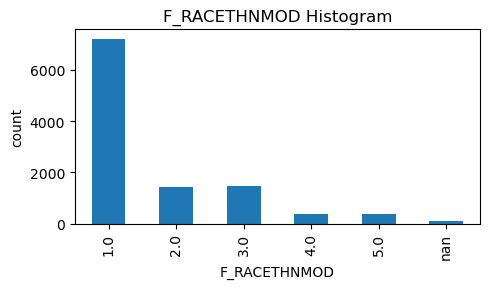

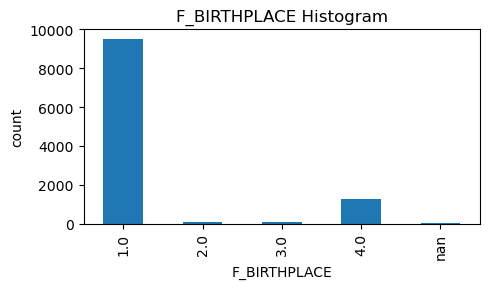

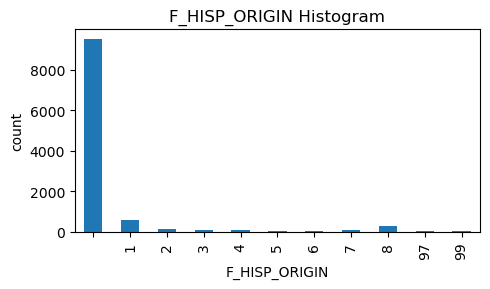

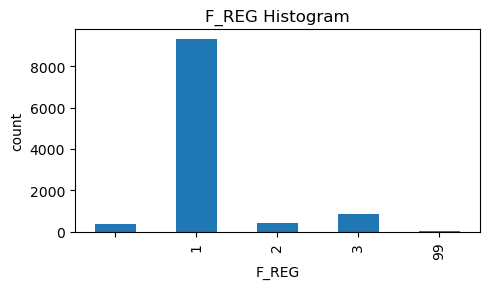

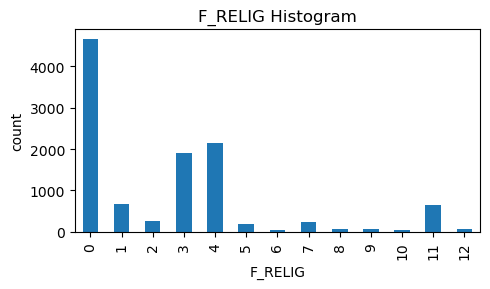

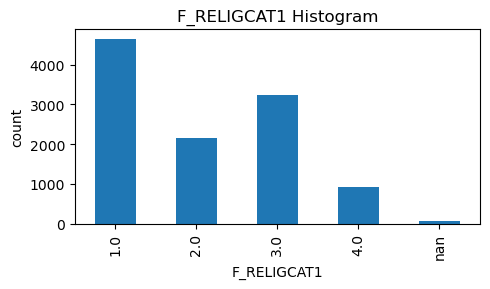

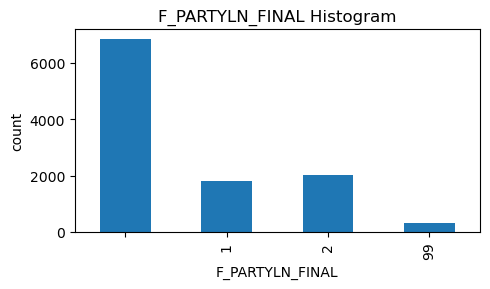

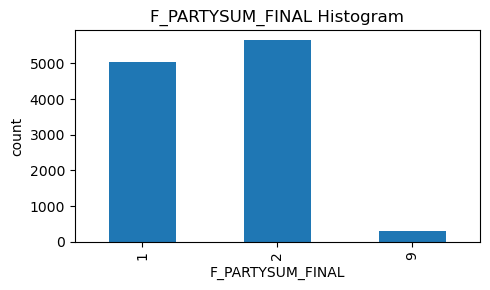

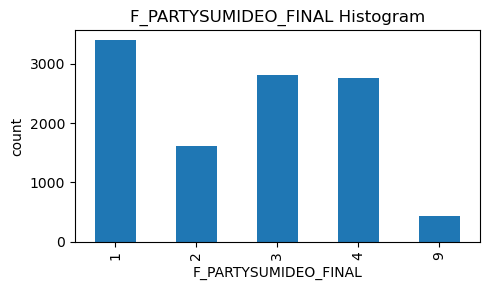

                        count      mean       std  min  25%  50%  75%  max
DESRISK_COMF_W119     10997.0  2.928435  0.927073  1.0  2.0  3.0  4.0  5.0
DESRISK_CREAT_W119    10998.0  2.338425  0.904576  1.0  2.0  2.0  3.0  5.0
DESRISK_NTECH_W119    10996.0  2.512550  1.005364  1.0  2.0  3.0  3.0  5.0
AIKNOW1_W119          10982.0  2.726188  3.074370  1.0  1.0  1.0  3.0  9.0
AIKNOW2_W119          10960.0  3.466880  2.787972  1.0  2.0  2.0  3.0  9.0
AIKNOW3_W119          10938.0  4.319711  2.745473  1.0  3.0  3.0  4.0  9.0
AIKNOW5_W119          10928.0  2.746065  3.157359  1.0  1.0  1.0  3.0  9.0
AIKNOW6_W119          10934.0  3.878544  2.405722  1.0  3.0  3.0  3.0  9.0
AIKNOW7_W119          10945.0  3.374509  2.763059  1.0  2.0  2.0  3.0  9.0
AIKNOW1_CORRECT_W119  11004.0  0.678844  0.466942  0.0  0.0  1.0  1.0  1.0
AIKNOW2_CORRECT_W119  11004.0  0.599328  0.490057  0.0  0.0  1.0  1.0  1.0
AIKNOW3_CORRECT_W119  11004.0  0.546529  0.497853  0.0  0.0  1.0  1.0  1.0
AIKNOW5_CORRECT_W119  110

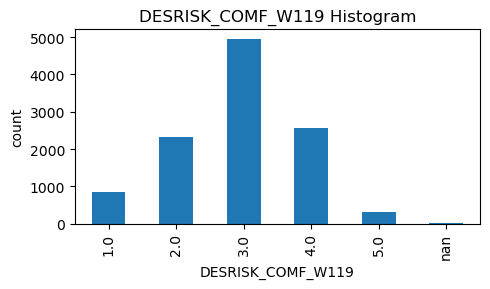

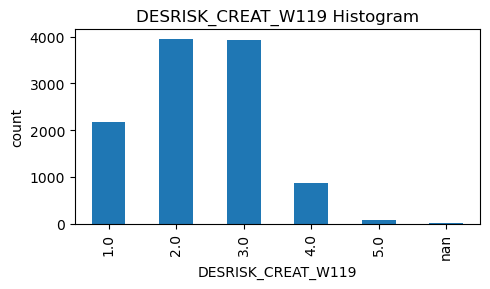

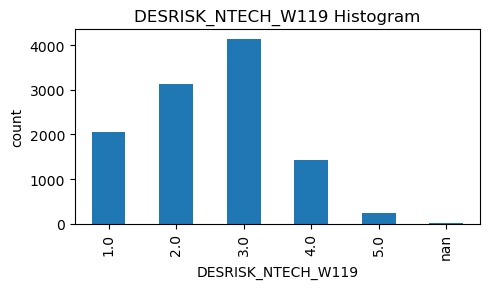

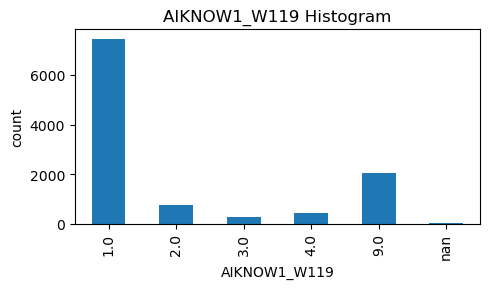

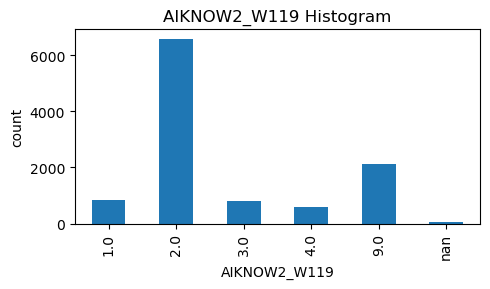

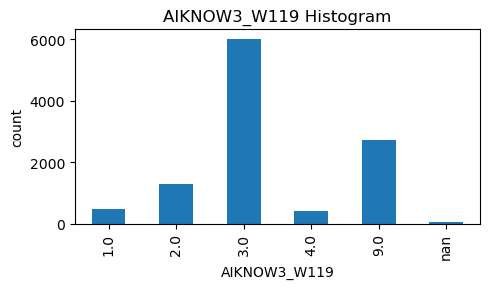

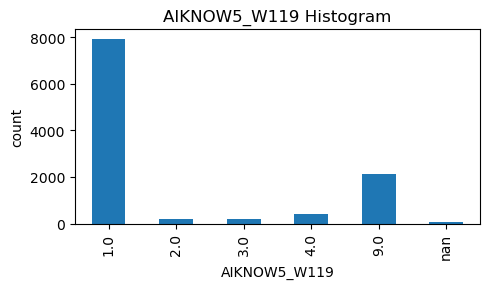

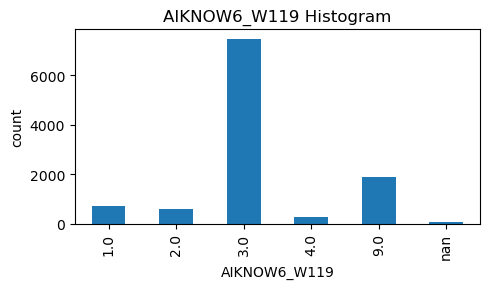

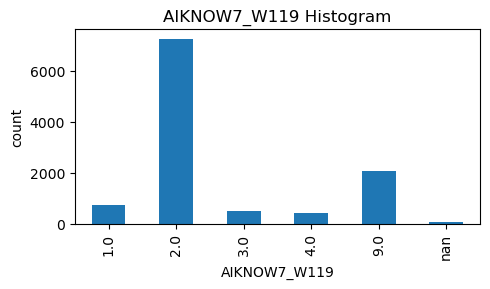

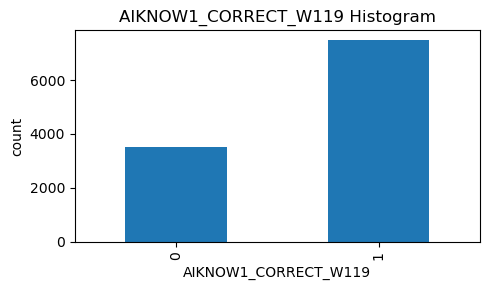

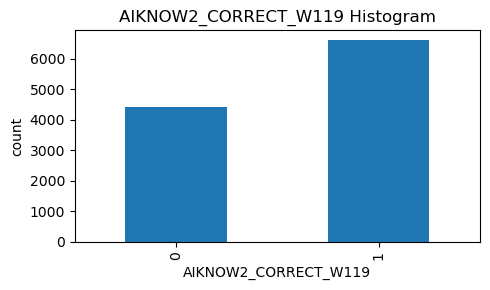

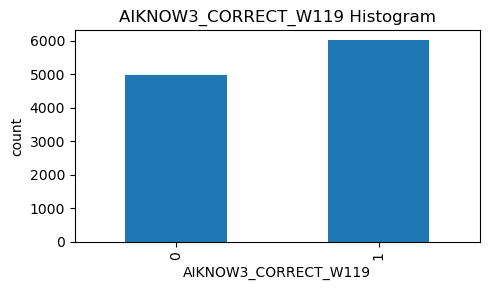

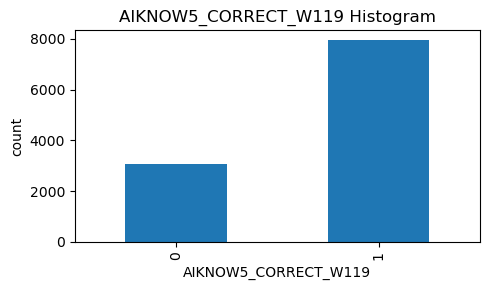

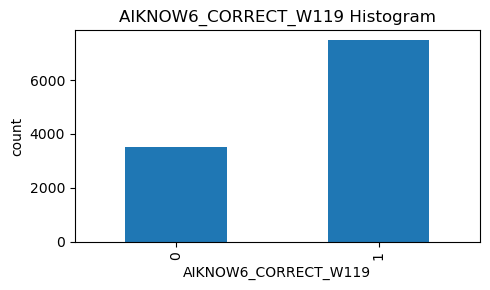

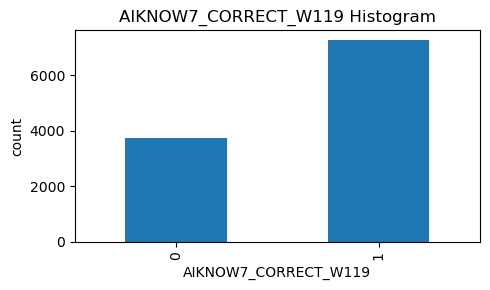

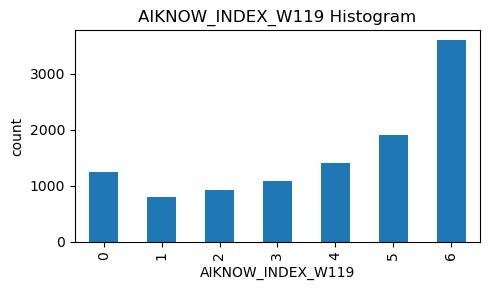

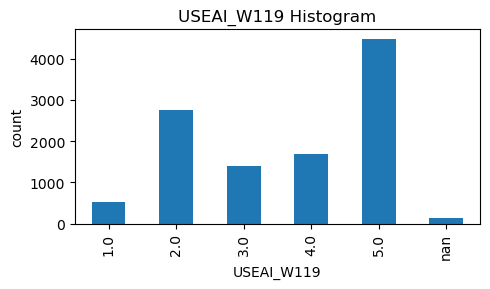

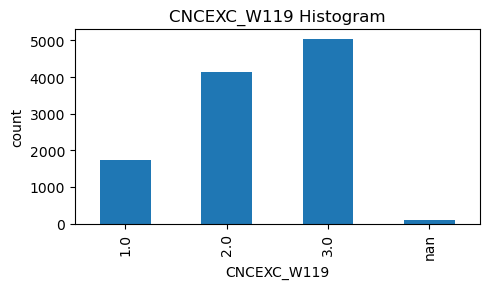

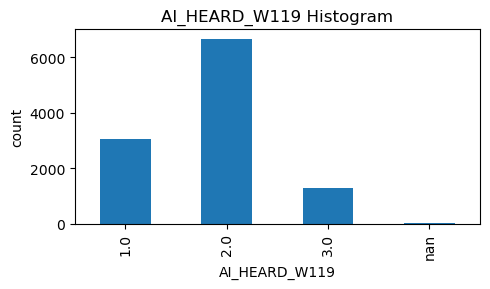

                        count      mean       std  min  25%  50%  75%  max
AIHCCOMF_W119         10946.0  2.744656  0.866899  1.0  2.0  3.0  3.0  4.0
AIHCTRT1_W119         10796.0  1.867821  0.808041  1.0  1.0  2.0  3.0  3.0
AIHCTRT2_W119         10806.0  1.229225  0.420353  1.0  1.0  1.0  1.0  2.0
MEDBIAS_W119          10826.0  1.894883  0.792131  1.0  1.0  2.0  3.0  3.0
HCMEDBIAS_W119        10828.0  2.605190  0.889435  1.0  2.0  3.0  3.0  5.0
AIHCCHG_QUAL_W119     10878.0  2.047527  0.835259  1.0  1.0  2.0  3.0  3.0
AIHCCHG_MIST_W119     10846.0  1.870920  0.848142  1.0  1.0  2.0  3.0  3.0
AIHCCHG_REL_W119      10911.0  2.174869  0.624166  1.0  2.0  2.0  3.0  3.0
AIHCCHG_RACETHN_W119  10885.0  2.055214  0.922971  1.0  1.0  2.0  3.0  3.0
AIHCCHG_SECUR_W119    10896.0  2.188968  0.770374  1.0  2.0  2.0  3.0  3.0
RISK2_W119            10896.0  1.425936  0.494507  1.0  1.0  1.0  2.0  2.0
FACERECWK1_W119       10916.0  2.219311  0.668989  1.0  2.0  2.0  3.0  3.0
FACERECWK2_a_W119     109

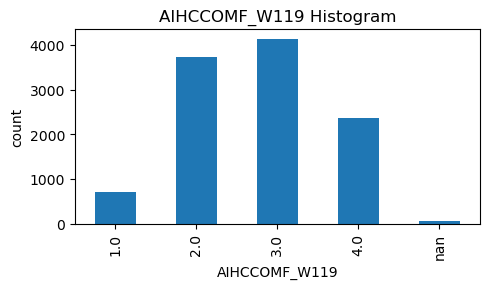

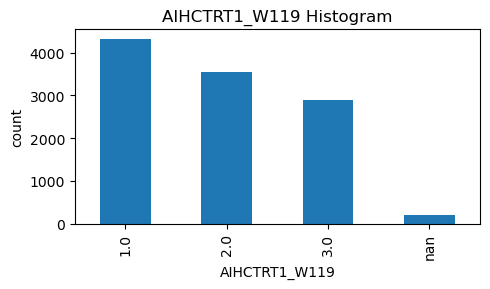

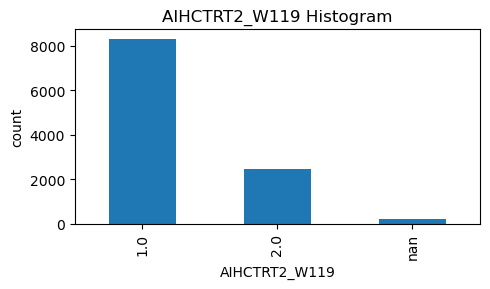

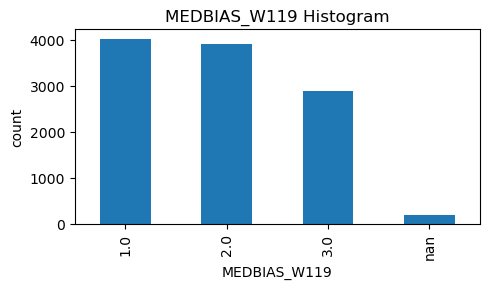

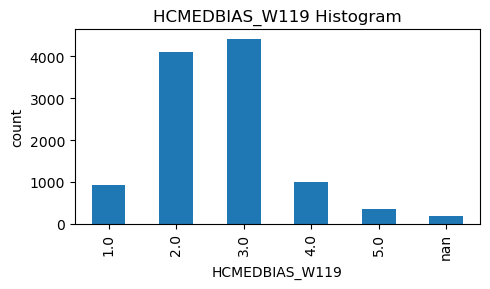

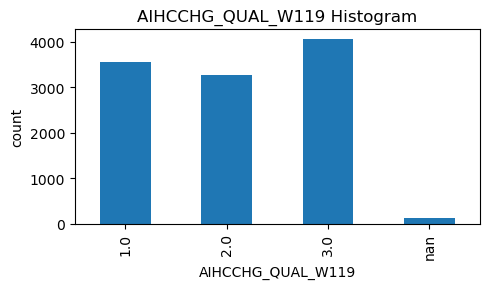

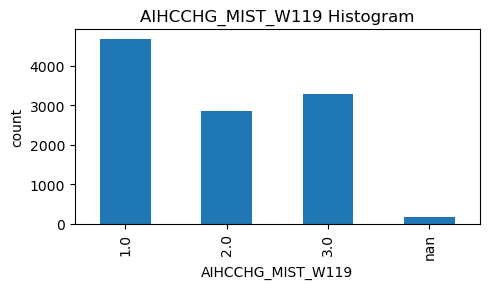

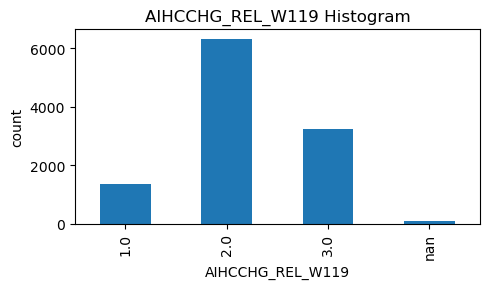

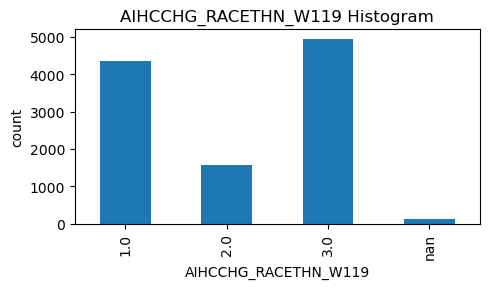

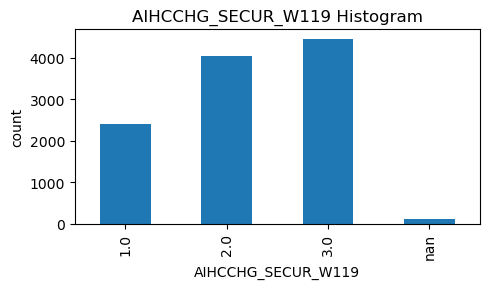

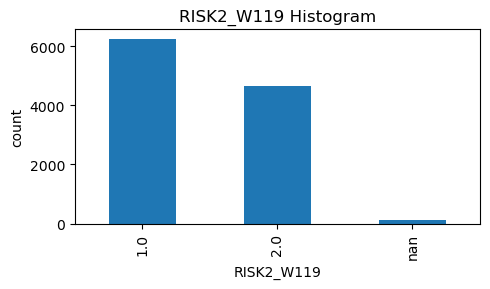

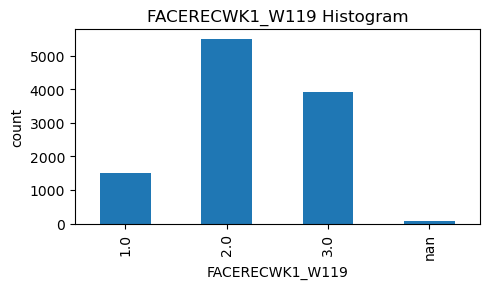

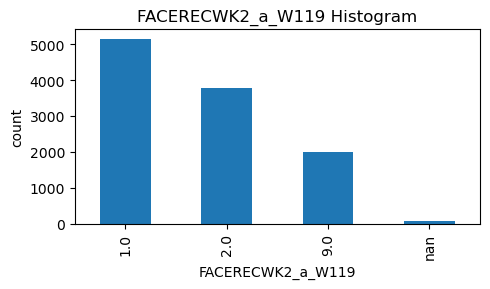

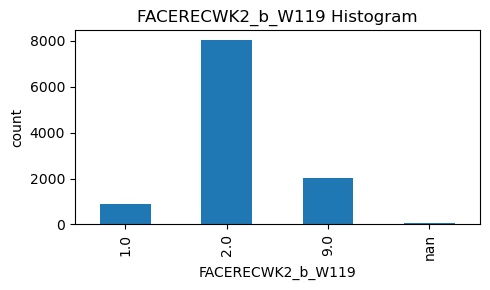

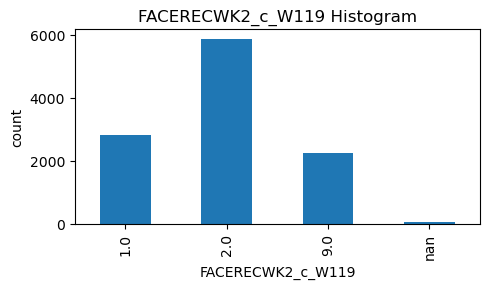

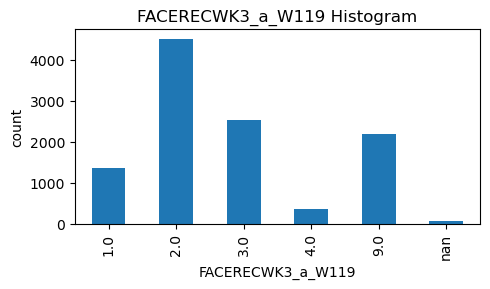

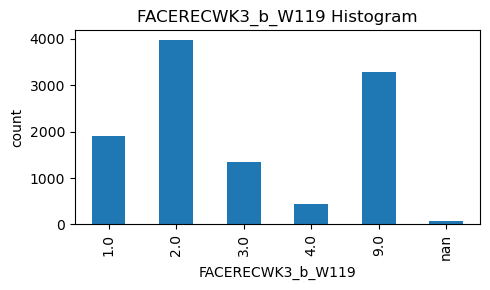

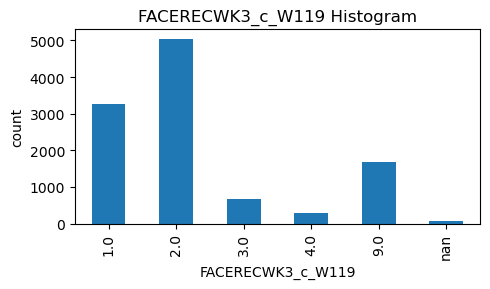

                      count      mean       std  min  25%  50%  75%  max
EMPLSIT_W119        10960.0  2.527281  1.720020  1.0  1.0  2.0  5.0  5.0
JOBAPPYR_W119       10980.0  1.767122  0.422684  1.0  2.0  2.0  2.0  2.0
INDUSTRYCOMBO_W119      0.0       NaN       NaN  NaN  NaN  NaN  NaN  NaN
AIWRK2_a_W119       10960.0  2.317336  2.677179  1.0  1.0  1.0  2.0  9.0
AIWRK2_b_W119       10959.0  3.112237  2.726338  1.0  1.0  2.0  3.0  9.0
AIWRK2_c_W119       10960.0  2.689416  2.983129  1.0  1.0  1.0  2.0  9.0
AIWRK3_a_W119       10948.0  3.590701  2.815981  1.0  2.0  3.0  3.0  9.0
AIWRK3_b_W119       10936.0  4.542337  3.450776  1.0  2.0  3.0  9.0  9.0
AIWRK3_c_W119       10951.0  3.754086  3.126595  1.0  2.0  2.0  9.0  9.0
AIWRKM1_W119        10881.0  2.548755  0.603024  1.0  2.0  3.0  3.0  3.0
AIWRKM2_a_W119      10936.0  3.385424  3.055985  1.0  2.0  2.0  2.0  9.0
AIWRKM2_b_W119      10934.0  3.214286  3.039797  1.0  1.0  2.0  2.0  9.0
AIWRKM2_c_W119      10933.0  3.367145  2.992525  1.

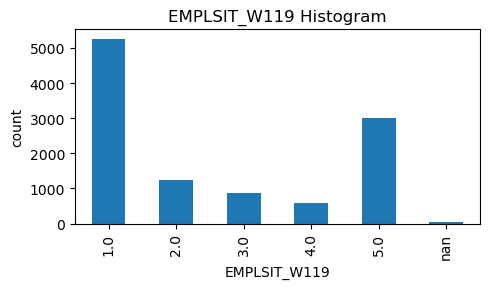

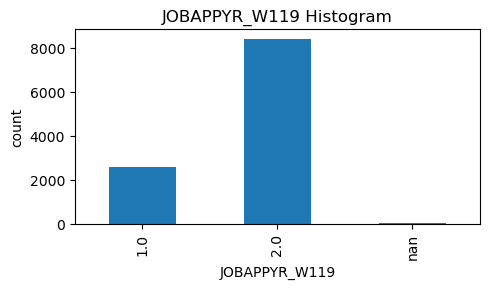

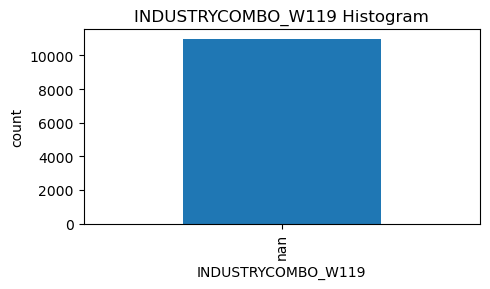

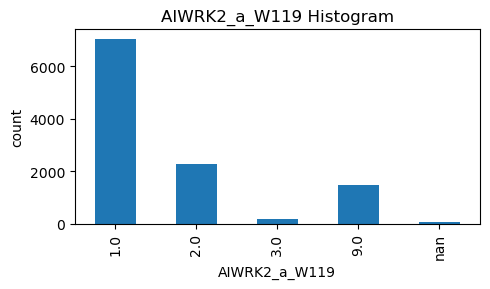

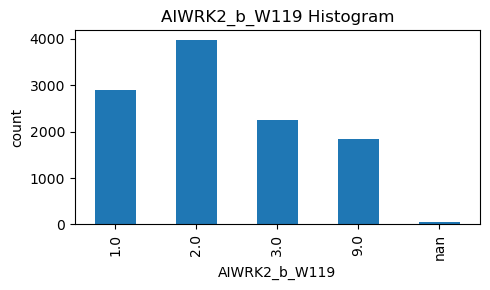

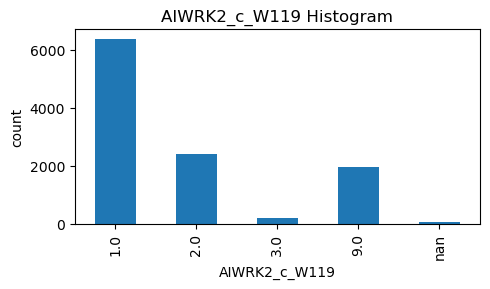

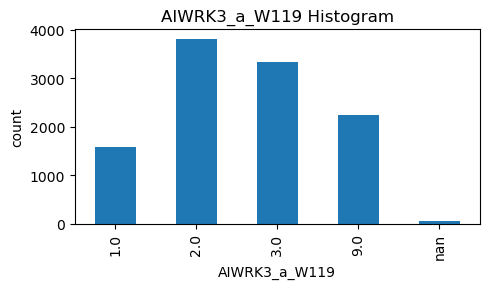

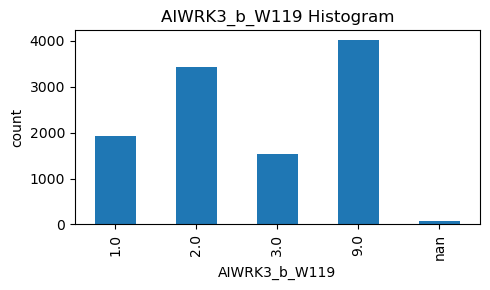

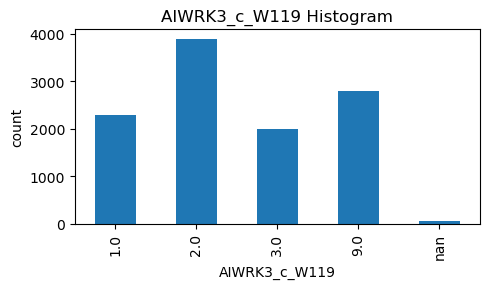

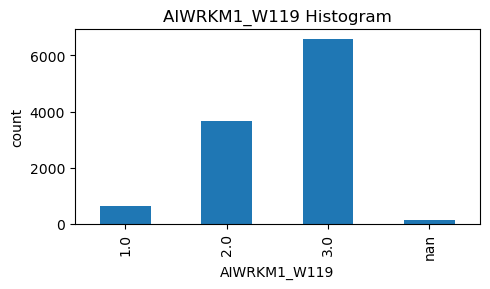

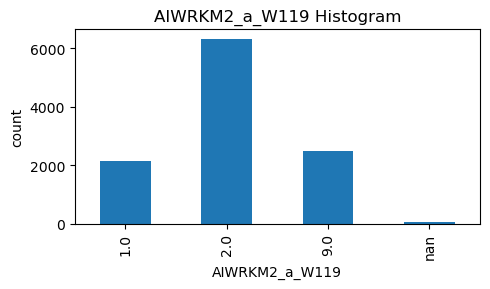

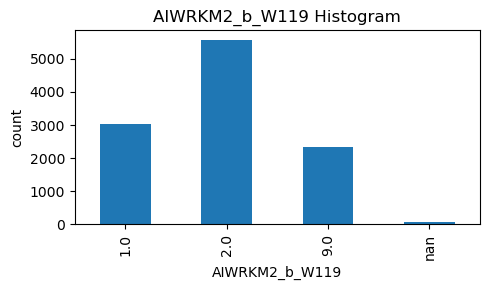

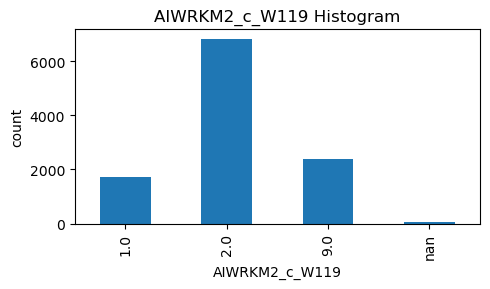

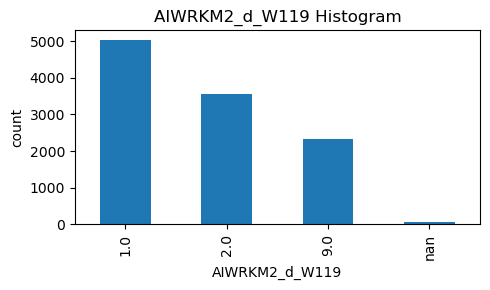

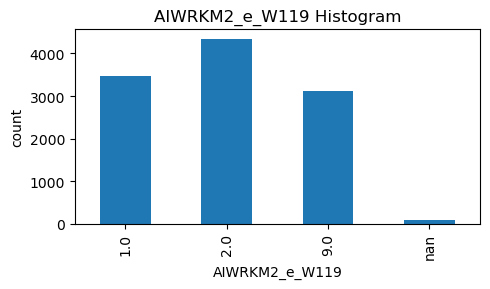

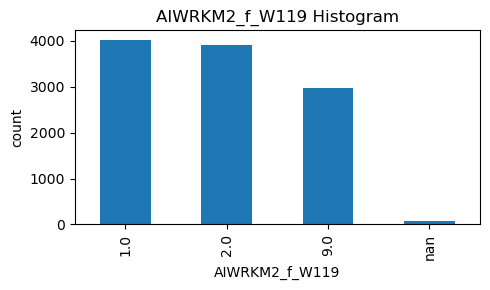

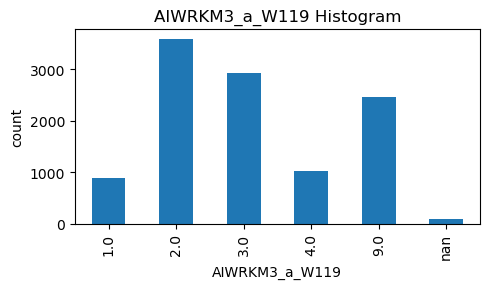

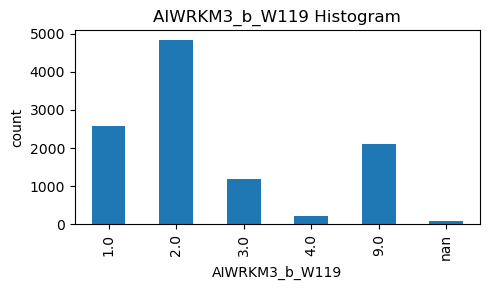

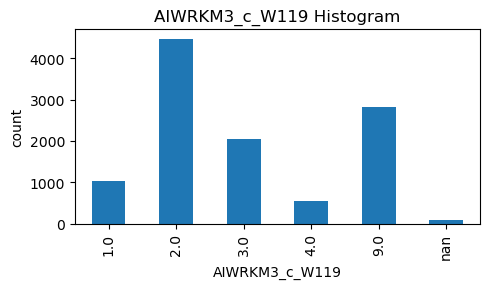

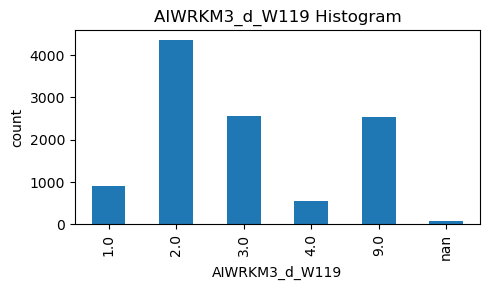

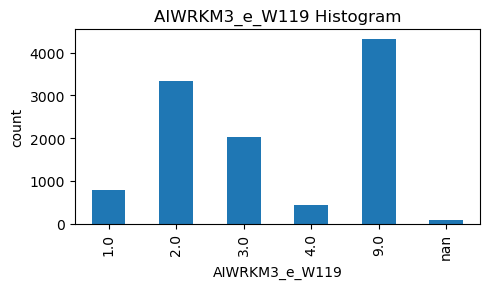

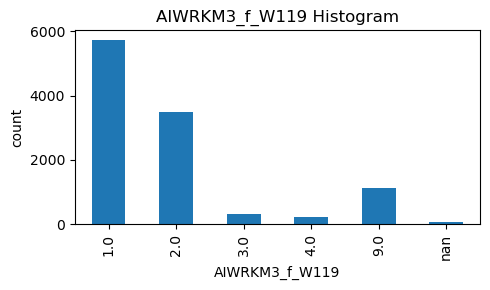

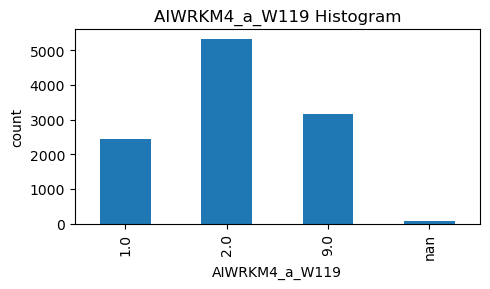

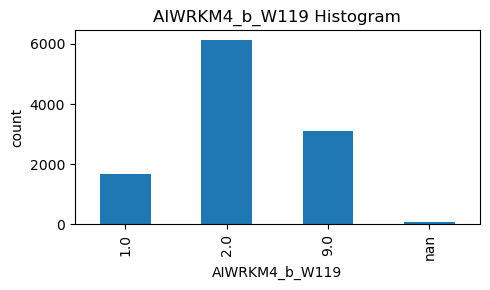

                     count unique  top  freq      mean       std  min  25%  \
DEVICE_TYPE_W119   11004.0    NaN  NaN   NaN  1.677027  0.524606  1.0  1.0   
LANG_W119          11004.0    NaN  NaN   NaN  1.039804  0.195507  1.0  1.0   
TWITTER1_MOD_W119  10983.0    NaN  NaN   NaN  1.705818  0.455695  1.0  1.0   
F_VOLSUM           10973.0    NaN  NaN   NaN  1.607765  0.488271  1.0  1.0   
F_INTFREQ            11004      7    2  5225       NaN       NaN  NaN  NaN   

                   50%  75%  max  
DEVICE_TYPE_W119   2.0  2.0  3.0  
LANG_W119          1.0  1.0  2.0  
TWITTER1_MOD_W119  2.0  2.0  2.0  
F_VOLSUM           2.0  2.0  2.0  
F_INTFREQ          NaN  NaN  NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11004 entries, 0 to 11003
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   DEVICE_TYPE_W119   11004 non-null  int64  
 1   LANG_W119          11004 non-null  int64  
 2   TWITTER1_MOD_W11

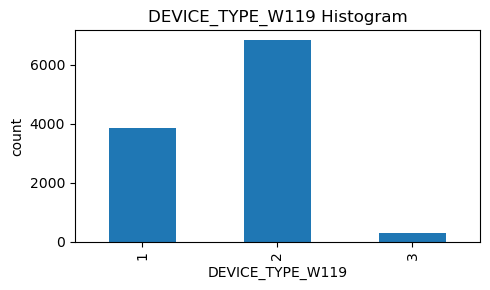

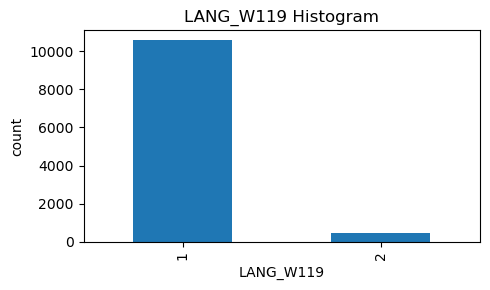

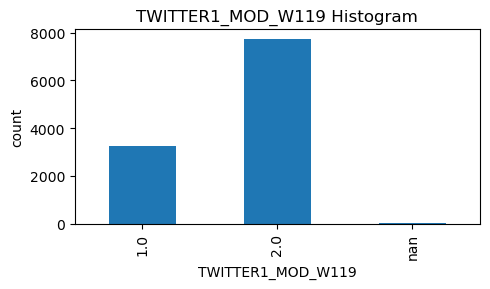

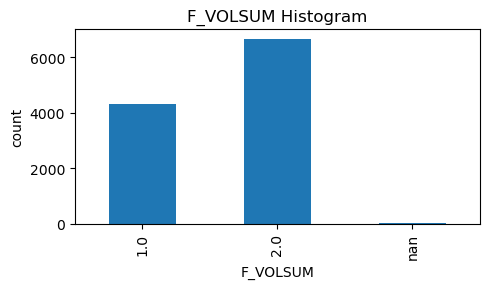

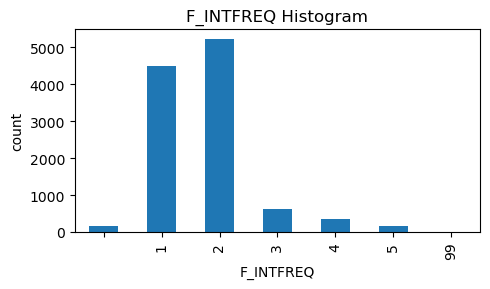

In [31]:
# Demographic variables
demographic_vars = [
    'F_AGECAT', 'F_GENDER', 'F_EDUCCAT', 'F_EDUCCAT2', 'F_RACECMB', 'F_RACETHNMOD',
    'F_CITIZEN', 'F_BIRTHPLACE', 'F_HISP', 'F_HISP_ORIGIN',
    'F_CREGION', 'F_CDIVISION', 'F_METRO', 'F_REG',
    'F_INC_SDT1', 'F_INC_TIER2', 'F_MARITAL',
    'F_RELIG', 'F_RELIGCAT1', 'F_ATTEND',
    'F_PARTY_FINAL', 'F_PARTYLN_FINAL', 'F_PARTYSUM_FINAL', 'F_PARTYSUMIDEO_FINAL', 'F_IDEO'
]

# Tech literacy & AI knowledge
tech_literacy_vars = [
    'DESRISK_COMF_W119', 'DESRISK_CREAT_W119', 'DESRISK_NTECH_W119',
    'AIKNOW1_W119', 'AIKNOW2_W119', 'AIKNOW3_W119', 'AIKNOW5_W119', 'AIKNOW6_W119', 'AIKNOW7_W119',
    'AIKNOW1_CORRECT_W119', 'AIKNOW2_CORRECT_W119', 'AIKNOW3_CORRECT_W119', 'AIKNOW5_CORRECT_W119', 'AIKNOW6_CORRECT_W119', 'AIKNOW7_CORRECT_W119',
    'AIKNOW_INDEX_W119', 'USEAI_W119', 'CNCEXC_W119', 'AI_HEARD_W119'
]

# Attitudes & Concerns
attitude_vars = [
    'AIHCCOMF_W119', 'AIHCTRT1_W119', 'AIHCTRT2_W119',
    'MEDBIAS_W119', 'HCMEDBIAS_W119', 'AIHCCHG_QUAL_W119', 'AIHCCHG_MIST_W119', 'AIHCCHG_REL_W119', 'AIHCCHG_RACETHN_W119', 'AIHCCHG_SECUR_W119',
    'RISK2_W119', 'FACERECWK1_W119', 'FACERECWK2_a_W119', 'FACERECWK2_b_W119', 'FACERECWK2_c_W119', 'FACERECWK3_a_W119', 'FACERECWK3_b_W119', 'FACERECWK3_c_W119'
]

# Employment & Reskilling
employment_vars = [
    'EMPLSIT_W119', 'JOBAPPYR_W119', 'INDUSTRYCOMBO_W119',
    'AIWRK2_a_W119', 'AIWRK2_b_W119', 'AIWRK2_c_W119', 'AIWRK3_a_W119', 'AIWRK3_b_W119', 'AIWRK3_c_W119',
    'AIWRKM1_W119', 'AIWRKM2_a_W119', 'AIWRKM2_b_W119', 'AIWRKM2_c_W119', 'AIWRKM2_d_W119', 'AIWRKM2_e_W119', 'AIWRKM2_f_W119',
    'AIWRKM3_a_W119', 'AIWRKM3_b_W119', 'AIWRKM3_c_W119', 'AIWRKM3_d_W119', 'AIWRKM3_e_W119', 'AIWRKM3_f_W119',
    'AIWRKM4_a_W119', 'AIWRKM4_b_W119'
]

# Behavior & Digital Engagement
behavior_vars = [
    'DEVICE_TYPE_W119', 'LANG_W119', 'TWITTER1_MOD_W119', 'F_VOLSUM', 'F_INTFREQ'
]

# Weight
weight_var = 'WEIGHT_W119'
analyze_subject(df, demographic_vars)
analyze_subject(df, tech_literacy_vars)
analyze_subject(df, attitude_vars)
analyze_subject(df, employment_vars)
analyze_subject(df, behavior_vars)
